# Importing Neccessary Libraries

In [281]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import emoji
import re
import time
import string
from googletrans import Translator
from deep_translator import GoogleTranslator
from gensim.models import KeyedVectors

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors

from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Setting Data Paths

In [286]:
data_path_train = 'Train\eRisk2023-T3_Subject'
no_of_training_instances = 46
data_path_test = 'Test\eRisk2022-T3_Subject'
no_of_testing_instances = 28
number_of_questions = 22

# Data Cleaning Functions

1. **Making the name of the Columns Same**

In [3]:
def make_coloumns_same(data_path, no_of_instances):

    for i in range(1, no_of_instances+1):
        df = pd.read_csv(f'{data_path}{i}.csv')
        
        # If a column is called "WRITING.TEXT", rename it to "WRITING.TEXT.Element:Text"
        if "WRITING.TEXT" in df.columns:
            df.rename(columns={"WRITING.TEXT": "WRITING.TEXT.Element:Text"}, inplace=True)
            df.to_csv(f'{data_path}{i}.csv', index=False)
        else:
            continue

2. **Following Data Cleaning operations are performed:**


    1. Remove the trailing b" and the ending "
    2. Replacing unicode characters with their actual characters
    3. Replacing emojis with their text descriptions

In [4]:
def data_cleaning(data_path, no_of_instances):

    for i in range(1, no_of_instances + 1):

        df = pd.read_csv(f'{data_path}{i}.csv')

        for index, row in df.iterrows():

            text_value = row['WRITING.TEXT.Element:Text']

            if isinstance(text_value, str):

                if ((text_value[2] == "'" or text_value[2] == '"') and (text_value[-2] == "'" or text_value[-2] == '"') and (text_value[0] == ' ' and text_value[1] == 'b' and text_value[-1] == ' ')):
                    df.at[index, 'WRITING.TEXT.Element:Text'] = text_value[3:-2]
                    text_value = text_value[3:-2]

                # Replace specific substrings
                text_value = text_value.replace('\\xe2\\x80\\x99', "'")
                text_value = text_value.replace('\\xe2\\x80\\x94', "-")
                text_value = text_value.replace('\\n', " ")

                # Define the regular expression pattern to match words starting with \xf0\x9f
                pattern = r'\\xf0\\x9f\S*'
                # Replace matched words with a single space
                text_value = re.sub(pattern, ' ', text_value)

                # Replace emoji with their text description
                text_value = emoji.demojize(text_value)
                df.at[index, 'WRITING.TEXT.Element:Text'] = text_value
                
            elif isinstance(text_value, float) and np.isnan(text_value):
                # Handle NaN values if needed
                pass
        
        df.to_csv(f'{data_path}{i}.csv', index=False)

3. **Making the final DataFrame before applying models to it**


In [284]:
def make_dataframe(data_path, no_of_instances, type):
    
    data_list = []
    no_of_posts_final = []
    df_final = pd.DataFrame(columns=['Subject', 'text'])

    if type == 'train':
        subject_name = 'eRisk2023-T3_Subject'
    
    else:
        subject_name = 'eRisk2022-T3_Subject'

    for i in range(1, no_of_instances+1):
        # Read the CSV file
        df = pd.read_csv(f'{data_path}{i}.csv')
        
        # Append the data to df
        data_to_append = ""

        no_of_posts = 0

        for index, row in df.iterrows():
            if isinstance(row['WRITING.TEXT.Element:Text'], str):
                data_to_append = data_to_append + row['WRITING.TEXT.Element:Text'] + " "
                no_of_posts += 1

        final_data = {'Subject': f'{subject_name}{i}', 'text': data_to_append}
        data_list.append(final_data)
        no_of_posts_final.append(no_of_posts)

    df_final = pd.DataFrame(data_list)
    return df_final, no_of_posts_final

# Data Preprocessing Functions

1. Lowercasing
2. Removing URLs
3. Removing Punctuations
4. Removing Stopwords
5. Lemmatization

In [95]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [96]:
def data_preprocessing(df):

    for index, row in df.iterrows():
        text_value = row['text']

            # lowercasing
        text_value = text_value.lower()

            # Remove URLs
        text_value = remove_urls(text_value)

            # Remove punctuation
        text_value = re.sub(r'[^\w\s]', '', text_value)

            # remove stopwords
        stop_words = set(stopwords.words('english'))
        text_value = ' '.join([word for word in text_value.split() if word not in stop_words])

            # lemmatization
        lemmatizer = WordNetLemmatizer()
        text_value = ' '.join([lemmatizer.lemmatize(word) for word in text_value.split()])
            
            # store the cleaned text
        df.at[index, 'text'] = text_value

    return df

In [97]:
def data_preprocessing_question(df):

    for index, row in df.iterrows():
        text_value = row['question']

            # lowercasing
        text_value = text_value.lower()

            # Remove URLs
        text_value = remove_urls(text_value)

            # Remove punctuation
        text_value = re.sub(r'[^\w\s]', '', text_value)

            # remove stopwords
        stop_words = set(stopwords.words('english'))
        text_value = ' '.join([word for word in text_value.split() if word not in stop_words])

            # lemmatization
        lemmatizer = WordNetLemmatizer()
        text_value = ' '.join([lemmatizer.lemmatize(word) for word in text_value.split()])
            
            # store the cleaned text
        df.at[index, 'question'] = text_value

    return df

In [98]:
def data_preprocessing_backtranslate(df):

    for index, row in df.iterrows():
        text_value = row['backtranslated']

            # lowercasing
        text_value = text_value.lower()

            # Remove URLs
        text_value = remove_urls(text_value)

            # Remove punctuation
        text_value = re.sub(r'[^\w\s]', '', text_value)

            # remove stopwords
        stop_words = set(stopwords.words('english'))
        text_value = ' '.join([word for word in text_value.split() if word not in stop_words])

            # lemmatization
        lemmatizer = WordNetLemmatizer()
        text_value = ' '.join([lemmatizer.lemmatize(word) for word in text_value.split()])
            
            # store the cleaned text
        df.at[index, 'backtranslated'] = text_value

    return df

# Storing all the labels in one Pandas DataFrame

In [169]:
def extract_labels(type):

    if type == 'train':

        label_list = []
        
        with open('golden-truth_eRisk2023_T3.txt', 'r') as file:
            for line in file:
                # go till the first space or tab is found
                index = 0
                while line[index] != ' ' and line[index] != '\t':
                    index += 1

                temp_list = []
                total_questions = 0

                # there are 22 questions, and each have an integer value separated by a space. store all these values sequentially in temp_list
                for i in range(22):
                    index += 1
                    while (line[index] == ' ' or line[index] == '\t'):
                        index += 1
                    temp_list.append(int(line[index]))
                    total_questions += 1

                label_list.append(temp_list)

    else:

        label_list = []
        
        with open('ground-truth_eRisk2022_T3.txt', 'r') as file:
            for line in file:
                # go till the first space or tab is found
                index = 0
                while line[index] != ' ' and line[index] != '\t':
                    index += 1

                temp_list = []
                total_questions = 0

                # there are 22 questions, and each have an integer value separated by a space. store all these values sequentially in temp_list
                for i in range(22):
                    index += 1
                    while (line[index] == ' ' or line[index] == '\t'):
                        index += 1
                    temp_list.append(int(line[index]))
                    total_questions += 1

                label_list.append(temp_list)

    return label_list

In [170]:
labels_train = extract_labels('train')
labels_test = extract_labels('test')

# Defining the Accuracy Metrics

In [153]:
def mean_zero_one_error(y_true, y_pred):

    individual_errors = []

    for i in range(len(y_true)):
        no_of_misclassifications = 0
        
        for j in range(len(y_true[i])):
            if y_true[i][j] != y_pred[i][j]:
                no_of_misclassifications += 1

        individual_errors.append(no_of_misclassifications/22.0)

    return np.mean(individual_errors)

In [154]:
def mean_absolute_error(y_true, y_pred):

    individual_errors = []

    for i in range(len(y_true)):
        total_error = 0
        
        for j in range(len(y_true[i])):
            total_error += abs(y_true[i][j] - y_pred[i][j])
            
        individual_errors.append(total_error/22.0)

    return np.mean(individual_errors)

In [155]:
def macroaveraged_mean_absolute_error(y_true, y_pred):

    individual_errors = []

    for i in range(len(y_true)):
        total_error = [0, 0, 0, 0, 0, 0, 0]
        total_points = [0, 0, 0, 0, 0, 0, 0]
        
        for j in range(len(y_true[i])):
            total_error[y_true[i][j]] += abs(y_true[i][j] - y_pred[i][j])
            total_points[y_true[i][j]] += 1

        final_error = 0

        for k in range(7):
            if total_points[k] != 0:
                final_error += total_error[k]/(total_points[k]*1.0)
        
        individual_errors.append(final_error/7.0)

    return np.mean(individual_errors)

In [156]:
def restrained_subscale(y_true, y_pred):
    
    indices = [0,1,2,3,4]
    total_error = 0

    for i in range(len(y_true)):

        system_score = 0
        real_score = 0

        for j in indices:
            system_score += y_pred[i][j]
            real_score += y_true[i][j]
        
        system_score = system_score/(len(indices)*1.0)
        real_score = real_score/(len(indices)*1.0)

        total_error += (system_score - real_score)**2

    total_error = total_error/(len(y_true)*1.0)
    total_error = np.sqrt(total_error)

    return total_error
    

In [157]:
def eating_concern_subscale(y_true, y_pred):
    
    indices = [6,8,12,13,14]
    total_error = 0

    for i in range(len(y_true)):

        system_score = 0
        real_score = 0

        for j in indices:
            system_score += y_pred[i][j]
            real_score += y_true[i][j]
        
        system_score = system_score/(len(indices)*1.0)
        real_score = real_score/(len(indices)*1.0)

        total_error += (system_score - real_score)**2

    total_error = total_error/(len(y_true)*1.0)
    total_error = np.sqrt(total_error)

    return total_error

In [158]:
def shape_concern_subscale(y_true, y_pred):
    
    indices = [5,7,9,10,16,19,20,21]
    total_error = 0

    for i in range(len(y_true)):

        system_score = 0
        real_score = 0

        for j in indices:
            system_score += y_pred[i][j]
            real_score += y_true[i][j]
        
        system_score = system_score/(len(indices)*1.0)
        real_score = real_score/(len(indices)*1.0)

        total_error += (system_score - real_score)**2

    total_error = total_error/(len(y_true)*1.0)
    total_error = np.sqrt(total_error)

    return total_error

In [159]:
def weight_concern_subscale(y_true, y_pred):

    indices = [7,11,15,17,18]
    total_error = 0

    for i in range(len(y_true)):

        system_score = 0
        real_score = 0

        for j in indices:
            system_score += y_pred[i][j]
            real_score += y_true[i][j]
        
        system_score = system_score/(len(indices)*1.0)
        real_score = real_score/(len(indices)*1.0)

        total_error += (system_score - real_score)**2

    total_error = total_error/(len(y_true)*1.0)
    total_error = np.sqrt(total_error)

    return total_error

In [160]:
def global_ED(y_true, y_pred):

    indices_r = [0,1,2,3,4]
    indices_e = [6,8,12,13,14]
    indices_s = [5,7,9,10,16,19,20,21]
    indices_w = [7,11,15,17,18]

    size_lists = [5,5,8,5]

    total_error = 0

    for i in range(len(y_true)):

        system_score = [0, 0, 0, 0]
        real_score = [0, 0, 0, 0]
        total_error_system = 0
        total_error_real = 0

        for j in indices_r:
            system_score[0] += y_pred[i][j]
            real_score[0] += y_true[i][j]
        
        for j in indices_e:
            system_score[1] += y_pred[i][j]
            real_score[1] += y_true[i][j]
        
        for j in indices_s:
            system_score[2] += y_pred[i][j]
            real_score[2] += y_true[i][j]
        
        for j in indices_w:
            system_score[3] += y_pred[i][j]
            real_score[3] += y_true[i][j]

        for k in range(4):
            system_score[k] = system_score[k]/(size_lists[k]*1.0)
            real_score[k] = real_score[k]/(size_lists[k]*1.0)

            total_error_system += system_score[k]
            total_error_real += real_score[k]
        
        total_error_system = total_error_system/(4.0)
        total_error_real = total_error_real/(4.0)

        total_error += (total_error_system - total_error_real)**2

    total_error = total_error/(len(y_true)*1.0)
    total_error = np.sqrt(total_error)

    return total_error

In [161]:
def find_all_metrics(y_true, y_pred):

    print("Mean Zero-One Error: ", mean_zero_one_error(y_true, y_pred))
    print("Mean Absolute Error: ", mean_absolute_error(y_true, y_pred))
    print("Macroaveraged Mean Absolute Error: ", macroaveraged_mean_absolute_error(y_true, y_pred))
    print("Restrained Subscale: ", restrained_subscale(y_true, y_pred))
    print("Eating Concern Subscale: ", eating_concern_subscale(y_true, y_pred))
    print("Shape Concern Subscale: ", shape_concern_subscale(y_true, y_pred))
    print("Weight Concern Subscale: ", weight_concern_subscale(y_true, y_pred))
    print("Global ED: ", global_ED(y_true, y_pred))

# Machine Learning Models

## Multinomial Naive Bayes

In [48]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer


def multinomial_naves_bayes(question_number, labels_train, labels_test, df_train, df_test):

    nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
    
    # Train the model
    X_train = df_train['text']
    y_train = []

    for i in range(len(labels_train)):
        y_train.append(labels_train[i][question_number])

    nb.fit(X_train, y_train)

    # Test the model
    X_test = df_test['text']
    y_pred = nb.predict(X_test)

    return y_pred

## Linear Support Vector Machine

In [77]:
from sklearn.linear_model import SGDClassifier

def linear_SVM(question_number, labels_train, labels_test, df_train, df_test):

    sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])

    # Train the model
    X_train = df_train['text']
    y_train = []

    for i in range(len(labels_train)):
        y_train.append(labels_train[i][question_number])
    
    sgd.fit(X_train, y_train)

    # Test the model
    X_test = df_test['text']
    y_pred = sgd.predict(X_test)

    return y_pred

## Logistic Regression

In [83]:
from sklearn.linear_model import LogisticRegression

def logistic_regression(question_number, labels_train, labels_test, df_train, df_test):

    logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])

    # Train the model
    X_train = df_train['text']
    y_train = []

    for i in range(len(labels_train)):
        y_train.append(labels_train[i][question_number])
    
    logreg.fit(X_train, y_train)

    # Test the model
    X_test = df_test['text']
    y_pred = logreg.predict(X_test)

    return y_pred

## Neural Network

In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

In [135]:
class CustomDataset(Dataset):
    def __init__(self, X, y, max_words):
        self.X = X
        self.y = y
        self.max_words = max_words
        self.vectorizer = CountVectorizer(max_features=max_words)
        self.vectorizer.fit(X)  # Fit the vectorizer with training data

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        text = self.X[idx]
        label = self.y[idx]
        text_vectorized = self.vectorizer.transform([text]).toarray().squeeze()
        return text_vectorized, label

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def neural_network(question_number, labels_train, labels_test, df_train, df_test):
    X_train = df_train['text']
    y_train = [labels_train[i][question_number] for i in range(len(labels_train))]
    X_test = df_test['text']
    y_test = [labels_test[i][question_number] for i in range(len(labels_test))]

    max_words = 1000
    dataset_train = CustomDataset(X_train, y_train, max_words)
    dataset_test = CustomDataset(X_test, y_test, max_words)

    train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
    test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

    input_size = max_words
    num_classes = 7

    model = NeuralNetwork(input_size, num_classes)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    epochs = 5
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            outputs = model(inputs.float())
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.tolist())

    return predictions

sample_nn = NeuralNetwork(1000, 7)
print(sample_nn)

NeuralNetwork(
  (fc1): Linear(in_features=1000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=7, bias=True)
)


# Preprocessing Training Data

In [287]:
df, no_of_posts = make_dataframe(data_path_train, no_of_training_instances, 'train')

In [10]:
make_coloumns_same(data_path_train, no_of_training_instances)
data_cleaning(data_path_train, no_of_training_instances)
df_train = make_dataframe(data_path_train, no_of_training_instances, 'train')
df_train = data_preprocessing(df_train)

df_train.head()

NameError: name 'make_coloumns_same' is not defined

In [36]:
df_train

,Subject,text
0,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...
1,eRisk2023-T3_Subject2,loved ideaconcept feel like film left many thi...
2,eRisk2023-T3_Subject3,dont need certification start working h motor ...
3,eRisk2023-T3_Subject4,leangains method rept fitness workout tracker ...
4,eRisk2023-T3_Subject5,think opinion system led anxiety havent change...
5,eRisk2023-T3_Subject6,volunteer waited late 30 family took much ther...
6,eRisk2023-T3_Subject7,find self thinking food lot wanting eat etc ac...
7,eRisk2023-T3_Subject8,wale country catalonia 3xe2x98xbaxefxb8x8f def...
8,eRisk2023-T3_Subject9,function word everything task content word muc...
9,eRisk2023-T3_Subject10,em polypharmacy much 80yo gramma taking idea s...


In [37]:
df_train.to_csv('train.csv', index=False)

# Data Visualisation

**Text Length V Instances Plot**

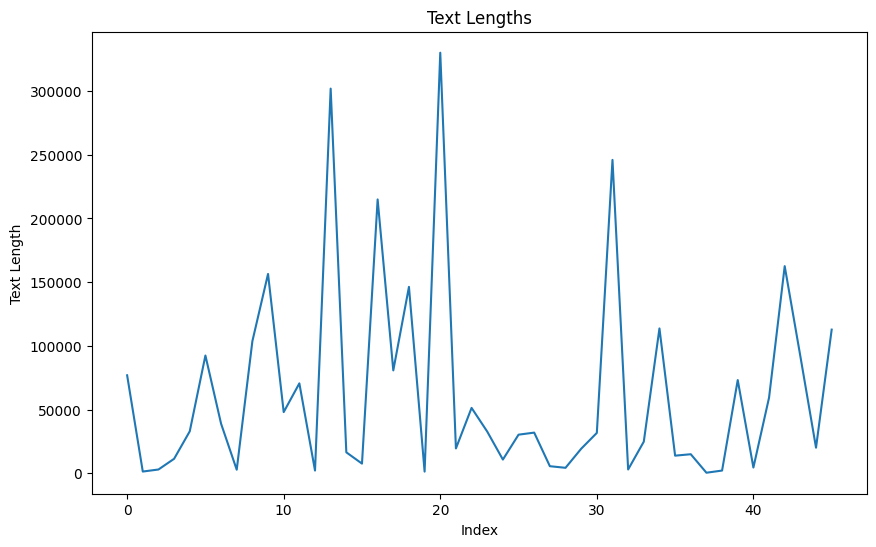

In [120]:
text_lengths = df_train['text'].apply(len)
plt.figure(figsize=(10, 6))
# plot a bar chartgraph
plt.plot(text_lengths)
plt.title('Text Lengths')
plt.xlabel('Index')
plt.ylabel('Text Length')
plt.show()

**Number of posts per user plot**

In [292]:
print(len(no_of_posts))
# print max, min and average of the no_of_posts list

max_posts = max(no_of_posts)
min_posts = min(no_of_posts)
avg_posts = sum(no_of_posts) / len(no_of_posts)
median_posts = sorted(no_of_posts)[len(no_of_posts) // 2] if len(no_of_posts) % 2 != 0 else (sorted(no_of_posts)[len(no_of_posts) // 2 - 1] + sorted(no_of_posts)[len(no_of_posts) // 2]) / 2


print("Maximum posts:", max_posts)
print("Minimum posts:", min_posts)
print("Average posts:", avg_posts)
print("Median posts:", median_posts)


46
Maximum posts: 1210
Minimum posts: 5
Average posts: 449.5652173913044
Median posts: 187.5


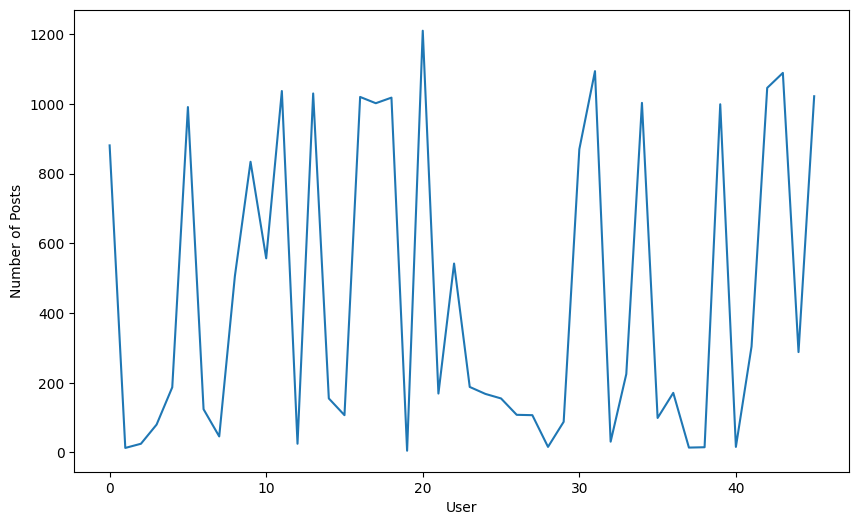

In [290]:
plt.figure(figsize=(10, 6))
# plot a bar chartgraph
plt.plot(no_of_posts)
plt.xlabel('User')
plt.ylabel('Number of Posts')
plt.show()

**Distribution of Text Length**

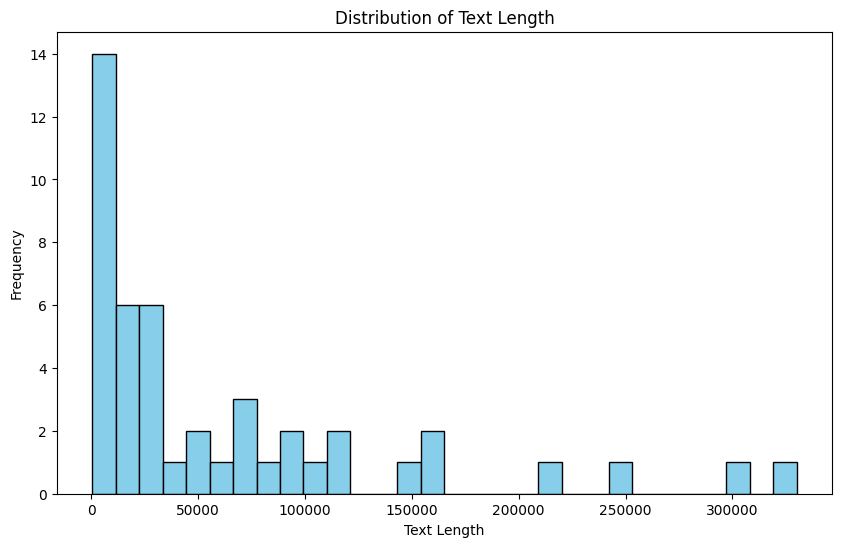

In [121]:
text_lengths = df_train['text'].apply(len)

# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

**Most Common N-Grams**

In [122]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer object
count_vectorizer = CountVectorizer(ngram_range=(2, 2))

# Fit and transform the text data
ngram_data = count_vectorizer.fit_transform(df_train['text'])

# Store the n-gram data in a DataFrame
ngram_df = pd.DataFrame(ngram_data.toarray(), columns=count_vectorizer.get_feature_names_out())

# Sum the occurrences of each n-gram
ngram_counts = ngram_df.sum()

# Sort the n-grams by frequency
ngram_counts = ngram_counts.sort_values(ascending=False)

# Display the 10 most common n-grams
ngram_counts.head(10)

feel like          543
dont know          445
eating disorder    403
dont want          288
dont think         282
look like          225
sound like         216
im sure            202
even though        180
make sense         153
dtype: int64

**Relevant Words Analysis using Word2Vec**

In [126]:
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')  # Make sure to have the punkt tokenizer downloaded

# Tokenize the sentences
tokenized_corpus = [nltk.word_tokenize(sentence.lower()) for sentence in df_train['text']]

# Train Word2Vec model
model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)

# Retrieve the word embedding for "food"
food_embedding = model.wv['food']

print("Word Embedding for 'food':", food_embedding)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91900\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


Word Embedding for 'food': [ 0.09896016  1.1175162   0.4014102   0.28502992 -0.07558895 -1.1316208
  0.3898303   1.9542687  -0.5694077  -0.42560315 -0.452752   -0.72157925
 -0.01915473  0.25941432  0.21395949 -0.7601462  -0.06205929 -0.9126611
  0.12396684 -1.5320469   0.6513112   0.13290778  0.19190112 -0.21886745
 -0.02676413 -0.30988935 -0.7881518  -0.5179168  -0.10626888  0.16344328
  1.0163852   0.58993095  0.3367984  -0.96814126 -0.28230283  0.8406765
 -0.06022361 -0.3941189  -0.54583406 -1.7474471   0.24584076 -0.9068461
 -0.40213487  0.23023677  0.7440899  -0.5860494  -0.62801987  0.00581882
  0.6883662   0.8939086   0.34958145 -0.6732001  -0.3933038  -0.6010126
 -0.61504453  0.7607724  -0.09765301  0.04697566 -1.1197114  -0.01455687
  0.14677206  0.56860375 -0.45509684 -0.0642701  -1.1386216   0.6442071
  0.45447597  0.6963921  -1.0590612   1.0109828  -0.61620593  0.27449298
  1.1017183  -0.06006506  0.6166811  -0.15906653  0.26821914 -0.00632291
 -0.3573404   0.63549906 -0.63

In [127]:
print("Shape of the word embedding:", food_embedding.shape)

Shape of the word embedding: (100,)


In [131]:
# Most similar words to "food" based on euclidean distance, top 100 words
similar_words = model.wv.most_similar('food', topn=100)
print(similar_words)

[('binge', 0.9995546340942383), ('meal', 0.9993753433227539), ('ed', 0.999364972114563), ('finish', 0.9993568658828735), ('fast', 0.9993310570716858), ('control', 0.9993168115615845), ('reason', 0.9992819428443909), ('straight', 0.9992722272872925), ('brain', 0.9992676973342896), ('voice', 0.9992669820785522), ('often', 0.9992617964744568), ('etc', 0.999255895614624), ('fat', 0.9992532730102539), ('felt', 0.999250054359436), ('healthy', 0.9992491006851196), ('le', 0.9992429614067078), ('water', 0.9992420673370361), ('calorie', 0.9992362856864929), ('little', 0.9992293119430542), ('pay', 0.9992249608039856), ('head', 0.9992240071296692), ('force', 0.9992235898971558), ('purging', 0.9992212653160095), ('longer', 0.9992210865020752), ('easy', 0.999218225479126), ('full', 0.9992106556892395), ('song', 0.9992095828056335), ('normal', 0.99920654296875), ('order', 0.9992055296897888), ('decision', 0.9992021918296814), ('moment', 0.9992009997367859), ('literally', 0.9991992712020874), ('energy

In [132]:
user_similar_words = []

for index, row in df_train.iterrows():
    text = row['text']
    user_similar_words.append({'Subject': row['Subject'], 'similar_words': {word: text.count(word) for word, _ in similar_words}})

# Convert the list of dictionaries to a DataFrame
user_similar_words_df = pd.DataFrame(user_similar_words)


# rank the users on the basis of the number of times the similar wordcount summation appear in their text
user_similar_words_df['score'] = user_similar_words_df['similar_words'].apply(lambda x: sum(x.values()))

# Sort the DataFrame based on the rank
user_similar_words_df = user_similar_words_df.sort_values(by='score', ascending=False)

# Display the DataFrame
user_similar_words_df

,Subject,similar_words,score
13,eRisk2023-T3_Subject14,"{'binge': 135, 'meal': 77, 'ed': 2563, 'finish...",10107
20,eRisk2023-T3_Subject21,"{'binge': 4, 'meal': 17, 'ed': 2613, 'finish':...",9436
31,eRisk2023-T3_Subject32,"{'binge': 0, 'meal': 12, 'ed': 1876, 'finish':...",7011
16,eRisk2023-T3_Subject17,"{'binge': 0, 'meal': 4, 'ed': 1653, 'finish': ...",6315
42,eRisk2023-T3_Subject43,"{'binge': 9, 'meal': 18, 'ed': 1398, 'finish':...",4895
9,eRisk2023-T3_Subject10,"{'binge': 0, 'meal': 9, 'ed': 1311, 'finish': ...",4812
18,eRisk2023-T3_Subject19,"{'binge': 0, 'meal': 3, 'ed': 1164, 'finish': ...",4520
45,eRisk2023-T3_Subject46,"{'binge': 2, 'meal': 0, 'ed': 1133, 'finish': ...",3738
34,eRisk2023-T3_Subject35,"{'binge': 0, 'meal': 5, 'ed': 730, 'finish': 1...",2705
8,eRisk2023-T3_Subject9,"{'binge': 0, 'meal': 1, 'ed': 639, 'finish': 0...",2607


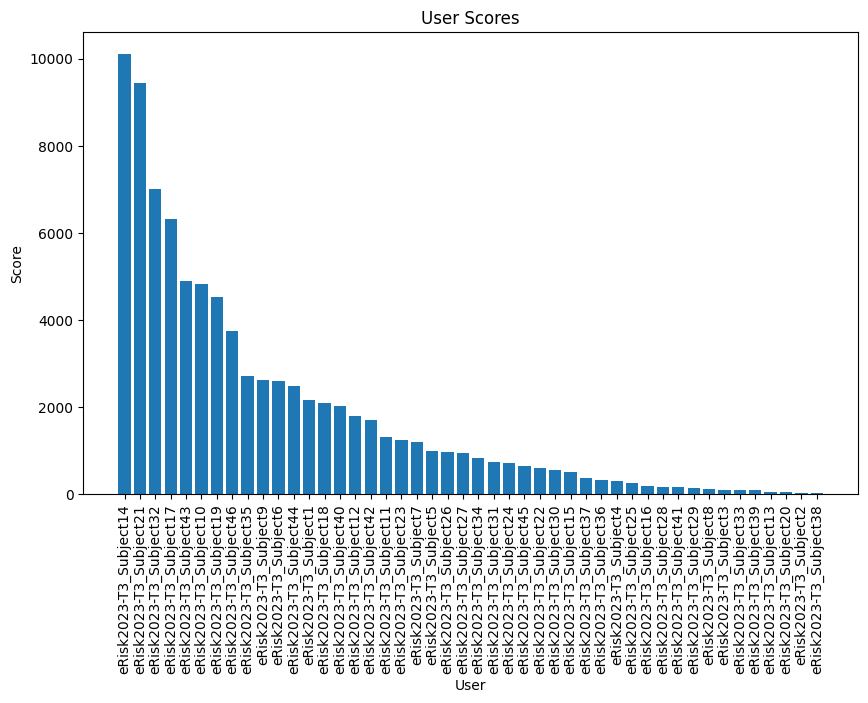

In [133]:
# plot the score of each user in the training set as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(user_similar_words_df['Subject'], user_similar_words_df['score'])
plt.title('User Scores')
plt.xlabel('User')
plt.ylabel('Score')
plt.xticks(rotation=90)
plt.show()

# Preprocessing Testing Data

In [38]:
make_coloumns_same(data_path_test, no_of_testing_instances)
data_cleaning(data_path_test, no_of_testing_instances)
df_test = make_dataframe(data_path_test, no_of_testing_instances, 'test')
df_test = data_preprocessing(df_test)

df_test.head()

,Subject,text
0,eRisk2022-T3_Subject1,thats thats post fucking utterly completely lo...
1,eRisk2022-T3_Subject2,shes wrong 25 warm rtightpussy thats spicy gir...
2,eRisk2022-T3_Subject3,feel way ill sometimes starve im feeling stres...
3,eRisk2022-T3_Subject4,yoga vvvv helpful slowly concentrate movement ...
4,eRisk2022-T3_Subject5,im experience ive owned patent leather suede b...


In [39]:
df_test

,Subject,text
0,eRisk2022-T3_Subject1,thats thats post fucking utterly completely lo...
1,eRisk2022-T3_Subject2,shes wrong 25 warm rtightpussy thats spicy gir...
2,eRisk2022-T3_Subject3,feel way ill sometimes starve im feeling stres...
3,eRisk2022-T3_Subject4,yoga vvvv helpful slowly concentrate movement ...
4,eRisk2022-T3_Subject5,im experience ive owned patent leather suede b...
5,eRisk2022-T3_Subject6,one find kidnapping inpregnation thing unsette...
6,eRisk2022-T3_Subject7,home rholup 175 favorite place visit paris wen...
7,eRisk2022-T3_Subject8,youre friend could honest directly tell making...
8,eRisk2022-T3_Subject9,oh fun ive lost equivalent beagle 16kg yup gnu...
9,eRisk2022-T3_Subject10,wash hair often greasy hair absorbs scent much...


In [40]:
df_test.to_csv('test.csv', index=False)

# Evaluating MidSem Models

## Multinomial Naives Bayes

In [50]:
multinomial_naive_bayes_predictions = []

for i in range(0, number_of_questions):
    print(f'Question {i+1}')
    multinomial_naive_bayes_predictions.append(multinomial_naves_bayes(i, labels_train, labels_test, df_train, df_test))

Question 1
Question 2
Question 3
Question 4
Question 5
Question 6
Question 7
Question 8
Question 9
Question 10
Question 11
Question 12
Question 13
Question 14
Question 15
Question 16
Question 17
Question 18
Question 19
Question 20
Question 21
Question 22


In [61]:
multinomial_naive_bayes_predictions_np = np.array(multinomial_naive_bayes_predictions)
multinomial_naive_bayes_predictions_np = multinomial_naive_bayes_predictions_np.T
print(multinomial_naive_bayes_predictions_np.shape)

(28, 22)


In [171]:
labels_test_np = np.array(labels_test)
print(labels_test_np.shape)

(28, 22)


In [76]:
find_all_metrics(labels_test_np, multinomial_naive_bayes_predictions_np)

Mean Zero-One Error:  0.6753246753246753
Mean Absolute Error:  2.340909090909091
Macroaveraged Mean Absolute Error:  1.7449807990523618
Restrained Subscale:  2.5793133083937563
Eating Concern Subscale:  3.0173308924090034
Shape Concern Subscale:  1.9142324086394824
Weight Concern Subscale:  1.9142324086394824
Global ED:  1.8380655410065536


## Linear Support Vector Machine

In [78]:
linear_support_vector_machine_predictions = []

for i in range(0, number_of_questions):
    print(f'Question {i+1}')
    linear_support_vector_machine_predictions.append(linear_SVM(i, labels_train, labels_test, df_train, df_test))

Question 1
Question 2
Question 3
Question 4
Question 5
Question 6
Question 7
Question 8
Question 9
Question 10
Question 11
Question 12
Question 13
Question 14
Question 15
Question 16
Question 17
Question 18
Question 19
Question 20
Question 21
Question 22


In [79]:
linear_support_vector_machine_predictions_np = np.array(linear_support_vector_machine_predictions)
linear_support_vector_machine_predictions_np = linear_support_vector_machine_predictions_np.T
print(linear_support_vector_machine_predictions_np.shape)

(28, 22)


In [82]:
find_all_metrics(labels_test_np, linear_support_vector_machine_predictions_np)

Mean Zero-One Error:  0.7012987012987012
Mean Absolute Error:  1.974025974025974
Macroaveraged Mean Absolute Error:  1.560444493074058
Restrained Subscale:  1.9867417691141587
Eating Concern Subscale:  1.6274432182326448
Shape Concern Subscale:  1.4177446878757824
Weight Concern Subscale:  1.4177446878757824
Global ED:  1.360584437350624


## Logistic Regression

In [114]:
logistic_regression_predictions = []

for i in range(0, number_of_questions):
    print(f'Question {i+1}')
    logistic_regression_predictions.append(logistic_regression(i, labels_train, labels_test, df_train, df_test))

Question 1
Question 2
Question 3
Question 4
Question 5
Question 6
Question 7
Question 8
Question 9
Question 10
Question 11
Question 12
Question 13
Question 14
Question 15
Question 16
Question 17
Question 18
Question 19
Question 20
Question 21
Question 22


In [85]:
logistic_regression_predictions_np = np.array(logistic_regression_predictions)
logistic_regression_predictions_np = logistic_regression_predictions_np.T
print(logistic_regression_predictions_np.shape)

(28, 22)


In [86]:
find_all_metrics(labels_test_np, logistic_regression_predictions_np)

Mean Zero-One Error:  0.6720779220779222
Mean Absolute Error:  2.043831168831169
Macroaveraged Mean Absolute Error:  1.6271578180144235
Restrained Subscale:  2.431636720987973
Eating Concern Subscale:  2.1480888515807983
Shape Concern Subscale:  1.6234883078464981
Weight Concern Subscale:  1.6234883078464981
Global ED:  1.5417501686684796


## Neural Network

In [115]:
neural_network_predictions = []

for i in range(0, number_of_questions):
    print(f'Question {i+1}')
    neural_network_predictions.append(neural_network(i, labels_train, labels_test, df_train, df_test))

Question 1
Question 2
Question 3
Question 4
Question 5
Question 6
Question 7
Question 8
Question 9
Question 10
Question 11
Question 12
Question 13
Question 14
Question 15
Question 16
Question 17
Question 18
Question 19
Question 20
Question 21
Question 22


In [116]:
neural_network_predictions_np = np.array(neural_network_predictions)
neural_network_predictions_np = neural_network_predictions_np.T
print(neural_network_predictions_np.shape)

(28, 22)


In [117]:
find_all_metrics(labels_test_np, neural_network_predictions_np)

Mean Zero-One Error:  0.7646103896103896
Mean Absolute Error:  2.586038961038961
Macroaveraged Mean Absolute Error:  1.7829061870818046
Restrained Subscale:  2.7446050977977032
Eating Concern Subscale:  2.80662481588524
Shape Concern Subscale:  2.239579042077838
Weight Concern Subscale:  2.239579042077838
Global ED:  2.336907869997691


# Results Obtained - MidSem Evaluation

In [118]:
summary_df = pd.DataFrame(columns=['Model', 'MAE', 'MZOE', 'MAE_macro', 'GED', 'RS', 'ECS', 'SCS', 'WCS'])

summary_df = summary_df.append({'Model': 'Multinomial Naive Bayes', 'MAE': mean_absolute_error(labels_test_np, multinomial_naive_bayes_predictions_np), 'MZOE': mean_zero_one_error(labels_test_np, multinomial_naive_bayes_predictions_np), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, multinomial_naive_bayes_predictions_np), 'GED': global_ED(labels_test_np, multinomial_naive_bayes_predictions_np), 'RS': restrained_subscale(labels_test_np, multinomial_naive_bayes_predictions_np), 'ECS': eating_concern_subscale(labels_test_np, multinomial_naive_bayes_predictions_np), 'SCS': shape_concern_subscale(labels_test_np, multinomial_naive_bayes_predictions_np), 'WCS': weight_concern_subscale(labels_test_np, multinomial_naive_bayes_predictions_np)}, ignore_index=True)
summary_df = summary_df.append({'Model': 'Linear Support Vector Machine', 'MAE': mean_absolute_error(labels_test_np, linear_support_vector_machine_predictions_np), 'MZOE': mean_zero_one_error(labels_test_np, linear_support_vector_machine_predictions_np), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, linear_support_vector_machine_predictions_np), 'GED': global_ED(labels_test_np, linear_support_vector_machine_predictions_np), 'RS': restrained_subscale(labels_test_np, linear_support_vector_machine_predictions_np), 'ECS': eating_concern_subscale(labels_test_np, linear_support_vector_machine_predictions_np), 'SCS': shape_concern_subscale(labels_test_np, linear_support_vector_machine_predictions_np), 'WCS': weight_concern_subscale(labels_test_np, linear_support_vector_machine_predictions_np)}, ignore_index=True)
summary_df = summary_df.append({'Model': 'Logistic Regression', 'MAE': mean_absolute_error(labels_test_np, logistic_regression_predictions_np), 'MZOE': mean_zero_one_error(labels_test_np, logistic_regression_predictions_np), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, logistic_regression_predictions_np), 'GED': global_ED(labels_test_np, logistic_regression_predictions_np), 'RS': restrained_subscale(labels_test_np, logistic_regression_predictions_np), 'ECS': eating_concern_subscale(labels_test_np, logistic_regression_predictions_np), 'SCS': shape_concern_subscale(labels_test_np, logistic_regression_predictions_np), 'WCS': weight_concern_subscale(labels_test_np, logistic_regression_predictions_np)}, ignore_index=True)
summary_df = summary_df.append({'Model': 'Neural Network', 'MAE': mean_absolute_error(labels_test_np, neural_network_predictions_np), 'MZOE': mean_zero_one_error(labels_test_np, neural_network_predictions_np), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, neural_network_predictions_np), 'GED': global_ED(labels_test_np, neural_network_predictions_np), 'RS': restrained_subscale(labels_test_np, neural_network_predictions_np), 'ECS': eating_concern_subscale(labels_test_np, neural_network_predictions_np), 'SCS': shape_concern_subscale(labels_test_np, neural_network_predictions_np), 'WCS': weight_concern_subscale(labels_test_np, neural_network_predictions_np)}, ignore_index=True)

C:\Users\91900\AppData\Local\Temp\ipykernel_28904\327278642.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({'Model': 'Multinomial Naive Bayes', 'MAE': mean_absolute_error(labels_test_np, multinomial_naive_bayes_predictions_np), 'MZOE': mean_zero_one_error(labels_test_np, multinomial_naive_bayes_predictions_np), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, multinomial_naive_bayes_predictions_np), 'GED': global_ED(labels_test_np, multinomial_naive_bayes_predictions_np), 'RS': restrained_subscale(labels_test_np, multinomial_naive_bayes_predictions_np), 'ECS': eating_concern_subscale(labels_test_np, multinomial_naive_bayes_predictions_np), 'SCS': shape_concern_subscale(labels_test_np, multinomial_naive_bayes_predictions_np), 'WCS': weight_concern_subscale(labels_test_np, multinomial_naive_bayes_predictions_np)}, ignore_index=True)
C:\Users\91900\App

In [119]:
summary_df

,Model,MAE,MZOE,MAE_macro,GED,RS,ECS,SCS,WCS
0,Multinomial Naive Bayes,2.340909,0.675325,1.744981,1.838066,2.579313,3.017331,1.914232,1.914232
1,Linear Support Vector Machine,1.974026,0.701299,1.560444,1.360584,1.986742,1.627443,1.417745,1.417745
2,Logistic Regression,2.043831,0.672078,1.627158,1.541750,2.431637,2.148089,1.623488,1.623488
3,Neural Network,2.586039,0.764610,1.782906,2.336908,2.744605,2.806625,2.239579,2.239579


# Extracting Question Embeddings

In [1]:
questions = ['Have you been deliberately trying to limit the amount of food you eat to influence your shape or weight (whether or not you have succeeded)',
             'Have you gone for long periods of time (8 waking hours or more) without eating anything at all in order to influence your shape or weight?',
             'Have you tried to exclude from your diet any foods that you like in order to influence your shape or weight (whether or not you have succeeded)?',
             'Have you tried to follow definite rules regarding your eating (for example, a calorie limit) in order to influence your shape or weight (whether or not you have succeeded)?',
             'Have you had a definite desire to have an empty stomach with the aim of influencing your shape or weight?',
             'Have you had a definite desire to have a totally flat stomach?',
             'Has thinking about food, eating or calories made it very difficult to concentrate on things you are interested in (for example, working, following a conversation, or reading)?',
             'Has thinking about shape or weight made it very difficult to concentrate on things you are interested in (for example, working, following a conversation, or reading)?',
             'Have you had a definite fear of losing control over eating?',
             'Have you had a definite fear that you might gain weight?',
             'Have you felt fat?',
             'Have you had a strong desire to lose weight?',
             'Over the past 28 days, on how many days have you eaten in secret (ie, furtively)? ... Do not count episodes of binge eating.',
             'On what proportion of the times that you have eaten have you felt guilty (felt that you’ve done wrong) because of its effect on your shape or weight? ... Do not count episodes of binge eating.',
             'Over the past 28 days, how concerned have you been about other people seeing you eat? ... Do not count episodes of binge eating',
             'Has your weight influenced how you think about (judge) yourself as a person?',
             'Has your shape influenced how you think about (judge) yourself as a person?',
             'How much would it have upset you if you had been asked to weigh yourself once a week (no more, or less, often) for the next four weeks?',
             'How dissatisfied have you been with your weight?',
             'How dissatisfied have you been with your shape?',
             'How uncomfortable have you felt seeing your body (for example, seeing your shape in the mirror, in a shop window reflection, while undressing or taking a bath or shower)?',
             'How uncomfortable have you felt about others seeing your shape or figure (for example, in communal changing rooms, when swimming, or wearing tight clothes)?'
]

In [4]:
train_df = pd.read_csv('train.csv')

In [35]:
def get_questions_dataframe(df, labels, questions):

    questions_df = pd.DataFrame(columns=['Subject', 'text', 'question'])

    for index, row in df.iterrows():
        data = [{'Subject': row['Subject'], 'text': row['text'], 'question': question} for question in questions]
        questions_df = pd.concat([questions_df, pd.DataFrame(data)])
    
    labels_linear = []

    for i in range(len(labels)):
        for j in range(22):
            labels_linear.append(labels_train[i][j])

    questions_df['label'] = labels_linear

    return questions_df

In [43]:
questions_df_train = get_questions_dataframe(train_df, labels_train, questions)

In [44]:
questions_df_train.shape

(1012, 4)

In [45]:
questions_df_train.head()

,Subject,text,question,label
0,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...,Have you been deliberately trying to limit the...,2
1,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...,Have you gone for long periods of time (8 waki...,0
2,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...,Have you tried to exclude from your diet any f...,0
3,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...,Have you tried to follow definite rules regard...,0
4,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...,Have you had a definite desire to have an empt...,0


In [ ]:
questions_df_train.to_csv('questions_df_train.csv', index=False)

In [33]:
test_df = pd.read_csv('test.csv')

In [39]:
questions_df_test = get_questions_dataframe(test_df, labels_test, questions)

In [40]:
questions_df_test.shape

(616, 4)

In [41]:
questions_df_test.to_csv('questions_df_test.csv', index = False)

# Working with New Dataset

## Preprocess

In [42]:
questions_df_train = pd.read_csv('questions_df_train.csv')

In [43]:
questions_df_test = pd.read_csv('questions_df_test.csv')

In [44]:
questions_df_train.head()

,Subject,text,question,label
0,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...,Have you been deliberately trying to limit the...,2
1,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...,Have you gone for long periods of time (8 waki...,0
2,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...,Have you tried to exclude from your diet any f...,0
3,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...,Have you tried to follow definite rules regard...,0
4,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...,Have you had a definite desire to have an empt...,0


In [45]:
questions_df_train = data_preprocessing_question(questions_df_train)

In [46]:
question_df_test = data_preprocessing_question(questions_df_test)

In [47]:
questions_df_train.head()

,Subject,text,question,label
0,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...,deliberately trying limit amount food eat infl...,2
1,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...,gone long period time 8 waking hour without ea...,0
2,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...,tried exclude diet food like order influence s...,0
3,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...,tried follow definite rule regarding eating ex...,0
4,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...,definite desire empty stomach aim influencing ...,0


In [48]:
questions_df_test.head()

,Subject,text,question,label
0,eRisk2022-T3_Subject1,thats thats post fucking utterly completely lo...,deliberately trying limit amount food eat infl...,2
1,eRisk2022-T3_Subject1,thats thats post fucking utterly completely lo...,gone long period time 8 waking hour without ea...,0
2,eRisk2022-T3_Subject1,thats thats post fucking utterly completely lo...,tried exclude diet food like order influence s...,0
3,eRisk2022-T3_Subject1,thats thats post fucking utterly completely lo...,tried follow definite rule regarding eating ex...,0
4,eRisk2022-T3_Subject1,thats thats post fucking utterly completely lo...,definite desire empty stomach aim influencing ...,0


## Naive Bayes

In [57]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

def multinomial_naves_bayes_new(labels_train, labels_test, df_train, df_test):
    # Concatenate text and question columns to create combined text
    df_train['combined_text'] = df_train['text'] + ' ' + df_train['question']
    df_test['combined_text'] = df_test['text'] + ' ' + df_test['question']

    nb = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', MultinomialNB()),
                  ])

    # Train the model
    X_train = df_train['combined_text']
    y_train = labels_train
    nb.fit(X_train, y_train)

    # Test the model
    X_test = df_test['combined_text']
    y_pred = nb.predict(X_test)

    return y_pred

## Linear Support Vector Machine

In [79]:
from sklearn.linear_model import SGDClassifier

def linear_SVM_new(labels_train, labels_test, df_train, df_test):

    df_train['combined_text'] = df_train['text'] + ' ' + df_train['question']
    df_test['combined_text'] = df_test['text'] + ' ' + df_test['question']

    sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])

    # Train the model
    X_train = df_train['combined_text']
    y_train = labels_train
    sgd.fit(X_train, y_train)

    # Test the model
    X_test = df_test['combined_text']
    y_pred = sgd.predict(X_test)

    return y_pred

## Logistic Regression

In [85]:
from sklearn.linear_model import LogisticRegression

def logistic_regression_new(labels_train, labels_test, df_train, df_test):

    df_train['combined_text'] = df_train['text'] + ' ' + df_train['question']
    df_test['combined_text'] = df_test['text'] + ' ' + df_test['question']

    logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])

    # Train the model
    X_train = df_train['combined_text']
    y_train = labels_train
    logreg.fit(X_train, y_train)

    # Test the model
    X_test = df_test['combined_text']
    y_pred = logreg.predict(X_test)

    return y_pred

## Predictions

In [146]:
def flatten_labels(labels):

    labels_flattened = []

    for i in range (len(labels)):
        for j in range (len(labels[0])):
            labels_flattened.append(labels[i][j])

    return labels_flattened

In [147]:
train_labels_one_d = flatten_labels(labels_train)
test_labels_one_d = flatten_labels(labels_test)

In [60]:
y_pred_multinomial_naive_bayes = multinomial_naves_bayes_new(train_labels_one_d, test_labels_one_d, questions_df_train, questions_df_test)

In [62]:
print(len(y_pred_multinomial_naive_bayes))

616


In [63]:
y_pred_2d = np.array(y_pred_multinomial_naive_bayes).reshape(28, 22)

In [66]:
y_pred_2d_list = y_pred_2d.tolist()

<class 'list'>


In [78]:
find_all_metrics(labels_test_np, y_pred_2d)

Mean Zero-One Error:  0.814935064935065
Mean Absolute Error:  3.3603896103896105
Macroaveraged Mean Absolute Error:  2.2857142857142856
Restrained Subscale:  3.6942039544593173
Eating Concern Subscale:  3.1845609699656516
Shape Concern Subscale:  4.278006461626056
Weight Concern Subscale:  3.8234240450898755
Global ED:  3.676851301191201


In [80]:
y_pred_linear_svm = linear_SVM_new(train_labels_one_d, test_labels_one_d, questions_df_train, questions_df_test)

In [81]:
y_pred_2d_lin_svm = np.array(y_pred_linear_svm).reshape(28, 22)

In [82]:
find_all_metrics(labels_test_np, y_pred_2d_lin_svm)

Mean Zero-One Error:  0.6185064935064934
Mean Absolute Error:  2.126623376623377
Macroaveraged Mean Absolute Error:  1.9740038872691936
Restrained Subscale:  3.0708305065568178
Eating Concern Subscale:  2.7137217459212195
Shape Concern Subscale:  2.48746859276655
Weight Concern Subscale:  2.497141222621237
Global ED:  2.5695026269688843


In [86]:
y_pred_logreg = logistic_regression_new(train_labels_one_d, test_labels_one_d, questions_df_train, questions_df_test)

c:\Users\91900\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [87]:
y_pred_logreg_2d = np.array(y_pred_logreg).reshape(28, 22)

In [88]:
find_all_metrics(labels_test_np, y_pred_logreg_2d)

Mean Zero-One Error:  0.7305194805194807
Mean Absolute Error:  2.399350649350649
Macroaveraged Mean Absolute Error:  1.7905143627854423
Restrained Subscale:  2.991893810185878
Eating Concern Subscale:  2.5809743453642793
Shape Concern Subscale:  2.907041942790447
Weight Concern Subscale:  2.52445184997796
Global ED:  2.6128695056530145


# Final Table

In [93]:
summary_df_2 = pd.DataFrame(columns=['Model', 'MAE', 'MZOE', 'MAE_macro', 'GED', 'RS', 'ECS', 'SCS', 'WCS'])

summary_df_2 = summary_df_2.append({'Model': 'Multinomial Naive Bayes', 'MAE': mean_absolute_error(labels_test_np, y_pred_2d), 'MZOE': mean_zero_one_error(labels_test_np, y_pred_2d), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, y_pred_2d), 'GED': global_ED(labels_test_np, y_pred_2d), 'RS': restrained_subscale(labels_test_np, y_pred_2d), 'ECS': eating_concern_subscale(labels_test_np, y_pred_2d), 'SCS': shape_concern_subscale(labels_test_np, y_pred_2d), 'WCS': weight_concern_subscale(labels_test_np, y_pred_2d)}, ignore_index=True)
summary_df_2 = summary_df_2.append({'Model': 'Linear Support Vector Machine', 'MAE': mean_absolute_error(labels_test_np, y_pred_2d_lin_svm), 'MZOE': mean_zero_one_error(labels_test_np, y_pred_2d_lin_svm), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, y_pred_2d_lin_svm), 'GED': global_ED(labels_test_np, y_pred_2d_lin_svm), 'RS': restrained_subscale(labels_test_np, y_pred_2d_lin_svm), 'ECS': eating_concern_subscale(labels_test_np, y_pred_2d_lin_svm), 'SCS': shape_concern_subscale(labels_test_np, y_pred_2d_lin_svm), 'WCS': weight_concern_subscale(labels_test_np, y_pred_2d_lin_svm)}, ignore_index=True)
summary_df_2 = summary_df_2.append({'Model': 'Logistic Regression', 'MAE': mean_absolute_error(labels_test_np, y_pred_logreg_2d), 'MZOE': mean_zero_one_error(labels_test_np, y_pred_logreg_2d), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, y_pred_logreg_2d), 'GED': global_ED(labels_test_np, y_pred_logreg_2d), 'RS': restrained_subscale(labels_test_np, y_pred_logreg_2d), 'ECS': eating_concern_subscale(labels_test_np, y_pred_logreg_2d), 'SCS': shape_concern_subscale(labels_test_np, y_pred_logreg_2d), 'WCS': weight_concern_subscale(labels_test_np, y_pred_logreg_2d)}, ignore_index=True)

C:\Users\91900\AppData\Local\Temp\ipykernel_26472\863126563.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df_2 = summary_df_2.append({'Model': 'Multinomial Naive Bayes', 'MAE': mean_absolute_error(labels_test_np, y_pred_2d), 'MZOE': mean_zero_one_error(labels_test_np, y_pred_2d), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, y_pred_2d), 'GED': global_ED(labels_test_np, y_pred_2d), 'RS': restrained_subscale(labels_test_np, y_pred_2d), 'ECS': eating_concern_subscale(labels_test_np, y_pred_2d), 'SCS': shape_concern_subscale(labels_test_np, y_pred_2d), 'WCS': weight_concern_subscale(labels_test_np, y_pred_2d)}, ignore_index=True)
C:\Users\91900\AppData\Local\Temp\ipykernel_26472\863126563.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df_2 = summary_df_2.append({'Model': 

In [94]:
summary_df_2

,Model,MAE,MZOE,MAE_macro,GED,RS,ECS,SCS,WCS
0,Multinomial Naive Bayes,3.360390,0.814935,2.285714,3.676851,3.694204,3.184561,4.278006,3.823424
1,Linear Support Vector Machine,2.126623,0.618506,1.974004,2.569503,3.070831,2.713722,2.487469,2.497141
2,Logistic Regression,2.399351,0.730519,1.790514,2.612870,2.991894,2.580974,2.907042,2.524452


In [98]:
summary_df_2.to_csv('summary_2.csv', index=False)

# Word Embeddings

## Word2Vec

In [116]:
word_vectors = KeyedVectors.load_word2vec_format('googlewordemb/GoogleNews-vectors-negative300.bin', binary=True)

In [117]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    # Tokenize
    tokens = word_tokenize(text)
    # Convert to lowercase
    tokens = [word.lower() for word in tokens]
    # Remove punctuation
    tokens = [word for word in tokens if word.isalpha()]
    # Remove stopwords
    tokens = [word for word in tokens if not word in stop_words]
    return tokens

In [118]:
def text_to_embeddings(text):
    tokens = preprocess_text(text)
    embeddings = []
    for token in tokens:
        if token in word_vectors:
            embeddings.append(word_vectors[token])
    if not embeddings:
        # If no embeddings found, return zeros
        return np.zeros(300)
    else:
        # Average the embeddings for all tokens
        return np.mean(embeddings, axis=0)

In [116]:
questions_df_train = pd.read_csv('questions_df_train.csv')

In [117]:
questions_df_train['finaltext'] = questions_df_train['text'] + ' ' + questions_df_train['question']

In [118]:
questions_df_train['embeddings'] = questions_df_train['finaltext'].apply(text_to_embeddings)

In [119]:
questions_df_train.head()

,Subject,text,question,label,finaltext,embeddings
0,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...,Have you been deliberately trying to limit the...,2,idk mate since 1796 using vaccine still waitin...,"[0.03400013, 0.023241315, 0.014655367, 0.09442..."
1,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...,Have you gone for long periods of time (8 waki...,0,idk mate since 1796 using vaccine still waitin...,"[0.033861037, 0.023289423, 0.014571838, 0.0944..."
2,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...,Have you tried to exclude from your diet any f...,0,idk mate since 1796 using vaccine still waitin...,"[0.03396365, 0.023302507, 0.014678202, 0.09443..."
3,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...,Have you tried to follow definite rules regard...,0,idk mate since 1796 using vaccine still waitin...,"[0.03396574, 0.023225555, 0.014704033, 0.09439..."
4,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...,Have you had a definite desire to have an empt...,0,idk mate since 1796 using vaccine still waitin...,"[0.03393882, 0.023243697, 0.014618031, 0.09438..."


In [121]:
X_train = np.vstack(questions_df_train['embeddings'].values)
y_train = questions_df_train['label'] 

In [126]:
question_df_test = pd.read_csv('questions_df_test.csv')

In [127]:
questions_df_test['finaltext'] = questions_df_test['text'] + ' ' + questions_df_test['question']

In [128]:
questions_df_test['embeddings'] = questions_df_test['finaltext'].apply(text_to_embeddings)

In [129]:
X_test = np.vstack(questions_df_test['embeddings'].values)

## Logistic Regression

In [167]:
classifier = LogisticRegression(max_iter=1000)  # You can adjust parameters as needed
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [168]:
y_pred_lg = classifier.predict(X_test)

In [169]:
y_pred_2d_lg = np.array(y_pred_lg).reshape(28, 22)

In [170]:
find_all_metrics(labels_test_np, y_pred_2d_lg)

Mean Zero-One Error:  0.6298701298701299
Mean Absolute Error:  2.185064935064935
Macroaveraged Mean Absolute Error:  1.9923469387755104
Restrained Subscale:  3.0002380857906212
Eating Concern Subscale:  2.8881531419626225
Shape Concern Subscale:  2.7349425431415764
Weight Concern Subscale:  2.4937063637428185
Global ED:  2.660012041796051


## Linear SVM

In [171]:
svm_classifier = LinearSVC(max_iter=10000)  # You can adjust parameters as needed
svm_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm_classifier.predict(X_test)

c:\Users\91900\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [172]:
print(y_pred_svm)

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0
 0 6 0 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 0 0 0 0 0 0 0 0 0 

In [173]:
y_pred_2d_svm = np.array(y_pred_svm).reshape(28, 22)
find_all_metrics(labels_test_np, y_pred_2d_svm)

Mean Zero-One Error:  0.6574675324675325
Mean Absolute Error:  2.37012987012987
Macroaveraged Mean Absolute Error:  2.0345238095238094
Restrained Subscale:  3.0708305065568178
Eating Concern Subscale:  2.6723451445179327
Shape Concern Subscale:  2.998883720891587
Weight Concern Subscale:  2.6341168213599464
Global ED:  2.7430319594122743


## Random Forest

In [174]:
from sklearn.ensemble import RandomForestClassifier

# Define and train the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust parameters as needed
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_classifier.predict(X_test)

In [175]:
print(y_pred_rf)

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4
 4 4 0 0 0 4 4 4 5 4 4 0 4 4 4 4 0 4 4 4 4 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 1 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 0 1
 0 0 1 0 0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1
 1 0 6 0 0 0 0 0 0 1 0 0 6 0 0 0 0 6 6 0 0 0 0 0 0 0 0 6 0 0 0 0 0 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 0 0 0 0 0 0 0 0 0 

In [176]:
y_pred_2d_rf = np.array(y_pred_rf).reshape(28, 22)
find_all_metrics(labels_test_np, y_pred_2d_rf)

Mean Zero-One Error:  0.6866883116883117
Mean Absolute Error:  2.400974025974026
Macroaveraged Mean Absolute Error:  2.0053114048649765
Restrained Subscale:  3.024896692450835
Eating Concern Subscale:  2.5272797346441207
Shape Concern Subscale:  2.946415043258987
Weight Concern Subscale:  2.877747134726846
Global ED:  2.7300322657204985


## Gradient Boosting

In [162]:
from sklearn.ensemble import GradientBoostingClassifier

# Define and train the Gradient Boosting model
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)  
# You can adjust parameters as needed
gb_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_gb = gb_classifier.predict(X_test)

In [163]:
print(y_pred_gb)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 6 2 2 2 2 2
 2 2 2 2 2 2 2 6 6 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 5 5 0 0 5 5 0 5 5 0 5 5 0 5 5 0 5 5 1 0
 4 0 4 0 4 4 0 1 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 4 0 0 0 0 0 0 0 4
 0 4 4 0 4 0 0 4 0 0 0 0 5 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 3 1
 1 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 4 4 4 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 

In [177]:
y_pred_2d_gb = np.array(y_pred_gb).reshape(28, 22)
find_all_metrics(labels_test_np, y_pred_2d_gb)

Mean Zero-One Error:  0.7840909090909091
Mean Absolute Error:  2.4642857142857144
Macroaveraged Mean Absolute Error:  1.7803864998380303
Restrained Subscale:  2.7581049394725463
Eating Concern Subscale:  2.2878561393334405
Shape Concern Subscale:  3.082297525501762
Weight Concern Subscale:  2.6473706632376643
Global ED:  2.5764799946722716


## Final Table and Store Results

In [181]:
summary_df_3 = pd.DataFrame(columns=['Model', 'MAE', 'MZOE', 'MAE_macro', 'GED', 'RS', 'ECS', 'SCS', 'WCS'])

summary_df_3 = summary_df_3.append({'Model': 'Logistic Regression (Word2Vec)', 'MAE': mean_absolute_error(labels_test_np, y_pred_2d_lg), 'MZOE': mean_zero_one_error(labels_test_np, y_pred_2d_lg), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, y_pred_2d_lg), 'GED': global_ED(labels_test_np, y_pred_2d_lg), 'RS': restrained_subscale(labels_test_np, y_pred_2d_lg), 'ECS': eating_concern_subscale(labels_test_np, y_pred_2d_lg), 'SCS': shape_concern_subscale(labels_test_np, y_pred_2d_lg), 'WCS': weight_concern_subscale(labels_test_np, y_pred_2d_lg)}, ignore_index=True)
summary_df_3 = summary_df_3.append({'Model': 'Linear Support Vector Machine (Word2Vec)', 'MAE': mean_absolute_error(labels_test_np, y_pred_2d_svm), 'MZOE': mean_zero_one_error(labels_test_np, y_pred_2d_svm), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, y_pred_2d_svm), 'GED': global_ED(labels_test_np, y_pred_2d_svm), 'RS': restrained_subscale(labels_test_np, y_pred_2d_svm), 'ECS': eating_concern_subscale(labels_test_np, y_pred_2d_svm), 'SCS': shape_concern_subscale(labels_test_np, y_pred_2d_svm), 'WCS': weight_concern_subscale(labels_test_np, y_pred_2d_svm)}, ignore_index=True)
summary_df_3 = summary_df_3.append({'Model': 'Random Forest (Word2Vec)', 'MAE': mean_absolute_error(labels_test_np, y_pred_2d_rf), 'MZOE': mean_zero_one_error(labels_test_np, y_pred_2d_rf), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, y_pred_2d_rf), 'GED': global_ED(labels_test_np, y_pred_2d_rf), 'RS': restrained_subscale(labels_test_np, y_pred_2d_rf), 'ECS': eating_concern_subscale(labels_test_np, y_pred_2d_rf), 'SCS': shape_concern_subscale(labels_test_np, y_pred_2d_rf), 'WCS': weight_concern_subscale(labels_test_np, y_pred_2d_rf)}, ignore_index=True)
summary_df_3 = summary_df_3.append({'Model': 'Gradient Boosting (Word2Vec)', 'MAE': mean_absolute_error(labels_test_np, y_pred_2d_gb), 'MZOE': mean_zero_one_error(labels_test_np, y_pred_2d_gb), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, y_pred_2d_gb), 'GED': global_ED(labels_test_np, y_pred_2d_gb), 'RS': restrained_subscale(labels_test_np, y_pred_2d_gb), 'ECS': eating_concern_subscale(labels_test_np, y_pred_2d_gb), 'SCS': shape_concern_subscale(labels_test_np, y_pred_2d_gb), 'WCS': weight_concern_subscale(labels_test_np, y_pred_2d_gb)}, ignore_index=True)

C:\Users\91900\AppData\Local\Temp\ipykernel_26472\4156447357.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df_3 = summary_df_3.append({'Model': 'Logistic Regression (Word2Vec)', 'MAE': mean_absolute_error(labels_test_np, y_pred_2d_lg), 'MZOE': mean_zero_one_error(labels_test_np, y_pred_2d_lg), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, y_pred_2d_lg), 'GED': global_ED(labels_test_np, y_pred_2d_lg), 'RS': restrained_subscale(labels_test_np, y_pred_2d_lg), 'ECS': eating_concern_subscale(labels_test_np, y_pred_2d_lg), 'SCS': shape_concern_subscale(labels_test_np, y_pred_2d_lg), 'WCS': weight_concern_subscale(labels_test_np, y_pred_2d_lg)}, ignore_index=True)
C:\Users\91900\AppData\Local\Temp\ipykernel_26472\4156447357.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df_3

In [182]:
summary_df_3.head()

,Model,MAE,MZOE,MAE_macro,GED,RS,ECS,SCS,WCS
0,Logistic Regression (Word2Vec),2.185065,0.629870,1.992347,2.660012,3.000238,2.888153,2.734943,2.493706
1,Linear Support Vector Machine (Word2Vec),2.370130,0.657468,2.034524,2.743032,3.070831,2.672345,2.998884,2.634117
2,Random Forest (Word2Vec),2.400974,0.686688,2.005311,2.730032,3.024897,2.527280,2.946415,2.877747
3,Gradient Boosting (Word2Vec),2.464286,0.784091,1.780386,2.576480,2.758105,2.287856,3.082298,2.647371


In [183]:
summary_df_3.to_csv('summary_3.csv', index=False)

# Backtranslation

## Without Dim Red

### Init

In [270]:
questions_df_train = pd.read_csv('questions_df_train.csv')

In [104]:
questions_df_test = pd.read_csv('questions_df_test.csv')

In [84]:
backtranslated_train_df = pd.read_csv('train.csv')

In [85]:
backtranslated_train_df.head()

,Subject,text
0,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...
1,eRisk2023-T3_Subject2,loved ideaconcept feel like film left many thi...
2,eRisk2023-T3_Subject3,dont need certification start working h motor ...
3,eRisk2023-T3_Subject4,leangains method rept fitness workout tracker ...
4,eRisk2023-T3_Subject5,think opinion system led anxiety havent change...


In [86]:
backtranslated_train_df['backtranslated'] = backtranslated_train_df['text']#add a new coloumn called backtranslated in the df and fill it with text it self

In [271]:
# count the values of the coloumn label in questions_df_train
questions_df_train['label'].value_counts()

0    305
6    215
1    141
4     90
3     89
2     86
5     86
Name: label, dtype: int64

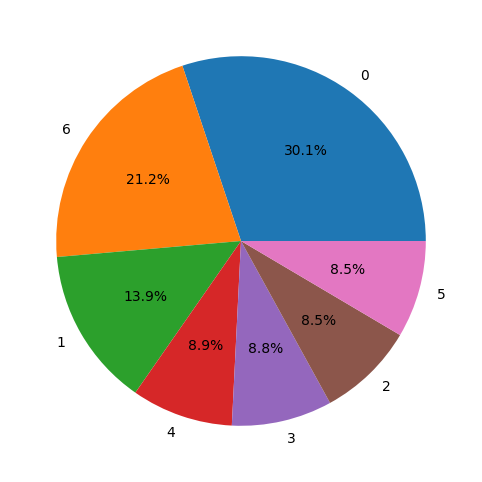

In [275]:
# make a pie chart on the label counts

plt.figure(figsize=(10, 6))
plt.pie(questions_df_train['label'].value_counts(), labels=['0', '6', '1', '4', '3', '2', '5'], autopct='%1.1f%%')
plt.show()

In [61]:
# find the percentages of each, give it in 100%
questions_df_train['label'].value_counts(normalize=True) * 100

0    30.138340
6    21.245059
1    13.932806
4     8.893281
3     8.794466
2     8.498024
5     8.498024
Name: label, dtype: float64

In [62]:
questions_df_test['label'].value_counts()

0    201
6    102
1     88
5     59
3     57
2     56
4     53
Name: label, dtype: int64

In [63]:
questions_df_test['label'].value_counts(normalize=True) * 100

0    32.629870
6    16.558442
1    14.285714
5     9.577922
3     9.253247
2     9.090909
4     8.603896
Name: label, dtype: float64

In [64]:
SOURCE_LANGUAGE = "en"
TARGET_LANGUAGE = "fr"
MAX_CHARACTERS = 4999

### Backtranslate Function

In [88]:
def backtranslate(text, src_lang, dest_lang):
    try:
        # Skip if the text is NaN or empty
        if pd.isna(text) or text == "":
            return text

        # Skip if the text is a link
        if re.match(r'https?://\S+', str(text)):
            return text

        # Split text into smaller chunks to avoid exceeding character limit
        chunk_size = 4999
        chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]
        
        # Translate each chunk
        translated_chunks = []
        for chunk in chunks:
            translated_chunk = GoogleTranslator(source=src_lang, target=dest_lang).translate(chunk)
            translated_chunks.append(translated_chunk)
        
        # Combine translated chunks and backtranslate
        translated_text = ' '.join(translated_chunks)

        chunks_2 = [translated_text[i:i+chunk_size] for i in range(0, len(translated_text), chunk_size)]

        # Translate each chunk back to original language now
        backtranslated_chunks = []
        for chunk in chunks_2:
            backtranslated_chunk = GoogleTranslator(source=dest_lang, target=src_lang).translate(chunk)
            backtranslated_chunks.append(backtranslated_chunk)

        # Combine backtranslated chunks
        backtranslated_text = ' '.join(backtranslated_chunks)
    
        return backtranslated_text

    except ValueError as e:
        print(f"Error Backtranslating text: {e}")
        return text  # Return the original text if translation fails

### Backtranslated Dataframe

In [87]:
done = 0
total = 46

In [90]:
done = 0  # Initialize counter

for index, row in backtranslated_train_df.iterrows():
    backtranslated_text = backtranslate(row['text'], SOURCE_LANGUAGE, TARGET_LANGUAGE)
    backtranslated_train_df.loc[index, 'backtranslated'] = backtranslated_text
    done += 1
    print(f"Progress: {done}/{total}")

Progress: 1/46
Progress: 2/46
Progress: 3/46
Progress: 4/46
Progress: 5/46
Progress: 6/46
Progress: 7/46
Progress: 8/46
Progress: 9/46
Progress: 10/46
Progress: 11/46
Progress: 12/46
Progress: 13/46
Progress: 14/46
Progress: 15/46
Progress: 16/46
Progress: 17/46
Progress: 18/46
Progress: 19/46
Progress: 20/46
Progress: 21/46
Progress: 22/46
Progress: 23/46
Progress: 24/46
Progress: 25/46
Progress: 26/46
Progress: 27/46
Progress: 28/46
Progress: 29/46
Progress: 30/46
Progress: 31/46
Progress: 32/46
Progress: 33/46
Progress: 34/46
Progress: 35/46
Progress: 36/46
Progress: 37/46
Progress: 38/46
Progress: 39/46
Progress: 40/46
Progress: 41/46
Progress: 42/46
Progress: 43/46
Progress: 44/46
Progress: 45/46
Progress: 46/46


In [91]:
backtranslated_train_df.to_csv('backtranslated_train.csv', index=False)

In [92]:
backtranslated_train_df.head()

,Subject,text,backtranslated
0,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...,I don't know buddy since 1796 I've been using ...
1,eRisk2023-T3_Subject2,loved ideaconcept feel like film left many thi...,I loved the idea the concept I have the impres...
2,eRisk2023-T3_Subject3,dont need certification start working h motor ...,no need certification start working engine h w...
3,eRisk2023-T3_Subject4,leangains method rept fitness workout tracker ...,leangains method rept fitness workout tracker ...
4,eRisk2023-T3_Subject5,think opinion system led anxiety havent change...,think opinion system drives anxiety hasn't cha...


In [99]:
backtranslated_train_df = data_preprocessing_backtranslate(backtranslated_train_df)

In [100]:
backtranslated_train_df.head()

,Subject,text,backtranslated
0,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...,dont know buddy since 1796 ive using vaccine i...
1,eRisk2023-T3_Subject2,loved ideaconcept feel like film left many thi...,loved idea concept impression film leaf lot th...
2,eRisk2023-T3_Subject3,dont need certification start working h motor ...,need certification start working engine h with...
3,eRisk2023-T3_Subject4,leangains method rept fitness workout tracker ...,leangains method rept fitness workout tracker ...
4,eRisk2023-T3_Subject5,think opinion system led anxiety havent change...,think opinion system drive anxiety hasnt chang...


In [101]:
backtranslated_train_df.shape

(46, 3)

### Increasing Train Set Size

In [108]:
extra_backtranslated_df = pd.DataFrame(columns=['Subject', 'text', 'question', 'label'])

In [109]:
for index, row in backtranslated_train_df.iterrows():
    for index1, row1 in questions_df_train.iterrows():
        if row['Subject'] == row1['Subject'] and row1['label'] in [2, 3, 4, 5]:
            data = {'Subject': row['Subject'], 'text': row['backtranslated'], 'question': row1['question'], 'label': row1['label']}
            extra_backtranslated_df = pd.concat([extra_backtranslated_df, pd.DataFrame(data, index=[0])])

In [111]:
extra_backtranslated_df.shape

(351, 4)

In [112]:
extra_backtranslated_df.head()

,Subject,text,question,label
0,eRisk2023-T3_Subject1,dont know buddy since 1796 ive using vaccine i...,Have you been deliberately trying to limit the...,2
0,eRisk2023-T3_Subject1,dont know buddy since 1796 ive using vaccine i...,Have you had a definite desire to have a total...,3
0,eRisk2023-T3_Subject1,dont know buddy since 1796 ive using vaccine i...,Has your shape influenced how you think about ...,2
0,eRisk2023-T3_Subject2,loved idea concept impression film leaf lot th...,Have you been deliberately trying to limit the...,5
0,eRisk2023-T3_Subject2,loved idea concept impression film leaf lot th...,Have you tried to exclude from your diet any f...,5


In [113]:
questions_df_train = pd.concat([questions_df_train, extra_backtranslated_df])

In [114]:
questions_df_train.shape

(1363, 4)

In [115]:
questions_df_train.to_csv('questions_df_train_with_backtranslation.csv', index=False)

In [276]:
questions_df_train_with_backtranslation = pd.read_csv('questions_df_train_with_backtranslation.csv')

In [277]:
questions_df_train_with_backtranslation['label'].value_counts()

0    305
6    215
4    180
3    178
2    172
5    172
1    141
Name: label, dtype: int64

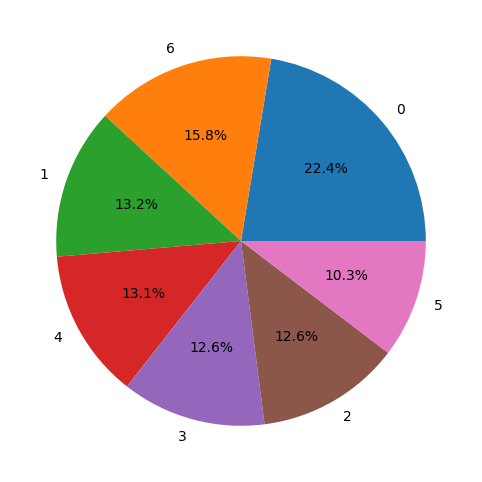

In [278]:
plt.figure(figsize=(10, 6))
plt.pie(questions_df_train_with_backtranslation['label'].value_counts(), labels=['0', '6', '1', '4', '3', '2', '5'], autopct='%1.1f%%')
plt.show()

### Word Embeddings Preprocessing

In [119]:
questions_df_train_with_backtranslation = pd.read_csv('questions_df_train_with_backtranslation.csv')

In [122]:
# shuffle the data frame
questions_df_train_with_backtranslation = questions_df_train_with_backtranslation.sample(frac=1).reset_index(drop=True)

In [123]:
questions_df_train_with_backtranslation.head()

,Subject,text,question,label
0,eRisk2023-T3_Subject42,joke he commercialised huge number product man...,How uncomfortable have you felt about others s...,2
1,eRisk2023-T3_Subject19,read comment section lot comment posted autist...,Have you had a definite desire to have a total...,1
2,eRisk2023-T3_Subject28,get never lost weight always feeling empty sto...,"Has thinking about food, eating or calories ma...",6
3,eRisk2023-T3_Subject21,might bit track post someone explain see much ...,How much would it have upset you if you had be...,1
4,eRisk2023-T3_Subject46,one mainly come im social setting ive tried lo...,Have you tried to exclude from your diet any f...,5


In [126]:
questions_df_train_with_backtranslation['text embeddings'] = questions_df_train_with_backtranslation['text'].apply(text_to_embeddings)

In [127]:
questions_df_train_with_backtranslation['question embeddings'] = questions_df_train_with_backtranslation['question'].apply(text_to_embeddings)

In [128]:
questions_df_train_with_backtranslation.head()

,Subject,text,question,label,text embeddings,question embeddings
0,eRisk2023-T3_Subject42,joke he commercialised huge number product man...,How uncomfortable have you felt about others s...,2,"[0.04482429, 0.016458541, 0.015856944, 0.09611...","[0.06806292, 0.111238204, -0.023045132, 0.1129..."
1,eRisk2023-T3_Subject19,read comment section lot comment posted autist...,Have you had a definite desire to have a total...,1,"[0.033100642, 0.020874992, 0.0064385766, 0.100...","[0.07992554, 0.03793945, 0.009521484, 0.136425..."
2,eRisk2023-T3_Subject28,get never lost weight always feeling empty sto...,"Has thinking about food, eating or calories ma...",6,"[0.024046626, 0.034505185, 0.0068059387, 0.110...","[0.05696106, 0.07692991, 0.05092948, 0.1493661..."
3,eRisk2023-T3_Subject21,might bit track post someone explain see much ...,How much would it have upset you if you had be...,1,"[0.04190163, 0.020787582, 0.0033705877, 0.1016...","[0.068392664, 0.07142223, -0.00074351917, 0.02..."
4,eRisk2023-T3_Subject46,one mainly come im social setting ive tried lo...,Have you tried to exclude from your diet any f...,5,"[0.042601615, 0.023390554, 0.006868688, 0.1052...","[0.07719283, 0.17119251, 0.08575578, 0.0619895..."


In [129]:
questions_df_train_with_backtranslation['embeddings'] = questions_df_train_with_backtranslation.apply(
    lambda row: np.concatenate((row['text embeddings'], row['question embeddings'])), axis=1)

In [130]:
questions_df_train_with_backtranslation.head()

,Subject,text,question,label,text embeddings,question embeddings,embeddings
0,eRisk2023-T3_Subject42,joke he commercialised huge number product man...,How uncomfortable have you felt about others s...,2,"[0.04482429, 0.016458541, 0.015856944, 0.09611...","[0.06806292, 0.111238204, -0.023045132, 0.1129...","[0.04482429, 0.016458541, 0.015856944, 0.09611..."
1,eRisk2023-T3_Subject19,read comment section lot comment posted autist...,Have you had a definite desire to have a total...,1,"[0.033100642, 0.020874992, 0.0064385766, 0.100...","[0.07992554, 0.03793945, 0.009521484, 0.136425...","[0.033100642, 0.020874992, 0.0064385766, 0.100..."
2,eRisk2023-T3_Subject28,get never lost weight always feeling empty sto...,"Has thinking about food, eating or calories ma...",6,"[0.024046626, 0.034505185, 0.0068059387, 0.110...","[0.05696106, 0.07692991, 0.05092948, 0.1493661...","[0.024046626, 0.034505185, 0.0068059387, 0.110..."
3,eRisk2023-T3_Subject21,might bit track post someone explain see much ...,How much would it have upset you if you had be...,1,"[0.04190163, 0.020787582, 0.0033705877, 0.1016...","[0.068392664, 0.07142223, -0.00074351917, 0.02...","[0.04190163, 0.020787582, 0.0033705877, 0.1016..."
4,eRisk2023-T3_Subject46,one mainly come im social setting ive tried lo...,Have you tried to exclude from your diet any f...,5,"[0.042601615, 0.023390554, 0.006868688, 0.1052...","[0.07719283, 0.17119251, 0.08575578, 0.0619895...","[0.042601615, 0.023390554, 0.006868688, 0.1052..."


In [143]:
X_train = np.vstack(questions_df_train_with_backtranslation['embeddings'].values)

In [144]:
X_train.shape

(1363, 600)

In [145]:
y_train = questions_df_train_with_backtranslation['label']

In [147]:
y_train.shape

(1363,)

In [164]:
questions_df_test = pd.read_csv('questions_df_test.csv')
questions_df_test.head()

,Subject,text,question,label
0,eRisk2022-T3_Subject1,thats thats post fucking utterly completely lo...,Have you been deliberately trying to limit the...,2
1,eRisk2022-T3_Subject1,thats thats post fucking utterly completely lo...,Have you gone for long periods of time (8 waki...,0
2,eRisk2022-T3_Subject1,thats thats post fucking utterly completely lo...,Have you tried to exclude from your diet any f...,0
3,eRisk2022-T3_Subject1,thats thats post fucking utterly completely lo...,Have you tried to follow definite rules regard...,0
4,eRisk2022-T3_Subject1,thats thats post fucking utterly completely lo...,Have you had a definite desire to have an empt...,0


In [165]:
questions_df_test['text embeddings'] = questions_df_test['text'].apply(text_to_embeddings)
questions_df_test['question embeddings'] = questions_df_test['question'].apply(text_to_embeddings)

In [166]:
questions_df_test['embeddings'] = questions_df_test.apply(
    lambda row: np.concatenate((row['text embeddings'], row['question embeddings'])), axis=1)

In [167]:
X_test = np.vstack(questions_df_test['embeddings'].values)

### Logistic Regression

In [152]:
classifier = LogisticRegression(max_iter=1000)  # You can adjust parameters as needed
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [172]:
y_pred_lg = classifier.predict(X_test)
y_pred_2d_lg = np.array(y_pred_lg).reshape(28, 22)
find_all_metrics(labels_test_np, y_pred_2d_lg)

Mean Zero-One Error:  0.6964285714285714
Mean Absolute Error:  2.0048701298701297
Macroaveraged Mean Absolute Error:  1.5419785936703228
Restrained Subscale:  2.2222896815157624
Eating Concern Subscale:  2.546987015503388
Shape Concern Subscale:  1.4394396851354547
Weight Concern Subscale:  1.4217695212053785
Global ED:  1.579956504402438


### Linear SVM

In [173]:
svm_classifier = LinearSVC(max_iter=10000) 
svm_classifier.fit(X_train, y_train)

y_pred_svm = svm_classifier.predict(X_test)

c:\Users\91900\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [174]:
y_pred_2d_svm = np.array(y_pred_svm).reshape(28, 22)
find_all_metrics(labels_test_np, y_pred_2d_svm)

Mean Zero-One Error:  0.6720779220779222
Mean Absolute Error:  1.9496753246753247
Macroaveraged Mean Absolute Error:  1.5926937783543587
Restrained Subscale:  2.2446762413701062
Eating Concern Subscale:  2.4233978507164573
Shape Concern Subscale:  1.511304131725785
Weight Concern Subscale:  1.4157279803287472
Global ED:  1.511513200080587


### Random Forest

In [176]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42) 
rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)

In [177]:
y_pred_2d_rf = np.array(y_pred_rf).reshape(28, 22)
find_all_metrics(labels_test_np, y_pred_2d_rf)

Mean Zero-One Error:  0.75487012987013
Mean Absolute Error:  1.9740259740259738
Macroaveraged Mean Absolute Error:  1.5476342177335731
Restrained Subscale:  2.090796157311509
Eating Concern Subscale:  2.0220216192146485
Shape Concern Subscale:  1.700512002729934
Weight Concern Subscale:  1.5514969729725085
Global ED:  1.6067510683163446


### Gradient Boosting

In [180]:
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42) 
gb_classifier.fit(X_train, y_train)

y_pred_gb = gb_classifier.predict(X_test)

In [181]:
y_pred_2d_gb = np.array(y_pred_gb).reshape(28, 22)
find_all_metrics(labels_test_np, y_pred_2d_gb)

Mean Zero-One Error:  0.7564935064935066
Mean Absolute Error:  1.8490259740259738
Macroaveraged Mean Absolute Error:  1.4130586060466563
Restrained Subscale:  1.9748417658131499
Eating Concern Subscale:  1.5847487407878167
Shape Concern Subscale:  1.4460151525584273
Weight Concern Subscale:  1.6660475040389116
Global ED:  1.386725069150592


### Final Table and Store Results

In [185]:
summary_df_4 = pd.DataFrame(columns=['Model', 'MAE', 'MZOE', 'MAE_macro', 'GED', 'RS', 'ECS', 'SCS', 'WCS'])

summary_df_4 = summary_df_4.append({'Model': 'Logistic Regression (Word2Vec + BT)', 'MAE': mean_absolute_error(labels_test_np, y_pred_2d_lg), 'MZOE': mean_zero_one_error(labels_test_np, y_pred_2d_lg), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, y_pred_2d_lg), 'GED': global_ED(labels_test_np, y_pred_2d_lg), 'RS': restrained_subscale(labels_test_np, y_pred_2d_lg), 'ECS': eating_concern_subscale(labels_test_np, y_pred_2d_lg), 'SCS': shape_concern_subscale(labels_test_np, y_pred_2d_lg), 'WCS': weight_concern_subscale(labels_test_np, y_pred_2d_lg)}, ignore_index=True)
summary_df_4 = summary_df_4.append({'Model': 'Linear Support Vector Machine (Word2Vec + BT)', 'MAE': mean_absolute_error(labels_test_np, y_pred_2d_svm), 'MZOE': mean_zero_one_error(labels_test_np, y_pred_2d_svm), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, y_pred_2d_svm), 'GED': global_ED(labels_test_np, y_pred_2d_svm), 'RS': restrained_subscale(labels_test_np, y_pred_2d_svm), 'ECS': eating_concern_subscale(labels_test_np, y_pred_2d_svm), 'SCS': shape_concern_subscale(labels_test_np, y_pred_2d_svm), 'WCS': weight_concern_subscale(labels_test_np, y_pred_2d_svm)}, ignore_index=True)
summary_df_4 = summary_df_4.append({'Model': 'Random Forest (Word2Vec + BT)', 'MAE': mean_absolute_error(labels_test_np, y_pred_2d_rf), 'MZOE': mean_zero_one_error(labels_test_np, y_pred_2d_rf), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, y_pred_2d_rf), 'GED': global_ED(labels_test_np, y_pred_2d_rf), 'RS': restrained_subscale(labels_test_np, y_pred_2d_rf), 'ECS': eating_concern_subscale(labels_test_np, y_pred_2d_rf), 'SCS': shape_concern_subscale(labels_test_np, y_pred_2d_rf), 'WCS': weight_concern_subscale(labels_test_np, y_pred_2d_rf)}, ignore_index=True)
summary_df_4 = summary_df_4.append({'Model': 'Gradient Boosting (Word2Vec + BT)', 'MAE': mean_absolute_error(labels_test_np, y_pred_2d_gb), 'MZOE': mean_zero_one_error(labels_test_np, y_pred_2d_gb), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, y_pred_2d_gb), 'GED': global_ED(labels_test_np, y_pred_2d_gb), 'RS': restrained_subscale(labels_test_np, y_pred_2d_gb), 'ECS': eating_concern_subscale(labels_test_np, y_pred_2d_gb), 'SCS': shape_concern_subscale(labels_test_np, y_pred_2d_gb), 'WCS': weight_concern_subscale(labels_test_np, y_pred_2d_gb)}, ignore_index=True)

C:\Users\91900\AppData\Local\Temp\ipykernel_40668\4144291010.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df_4 = summary_df_4.append({'Model': 'Logistic Regression (Word2Vec + BT)', 'MAE': mean_absolute_error(labels_test_np, y_pred_2d_lg), 'MZOE': mean_zero_one_error(labels_test_np, y_pred_2d_lg), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, y_pred_2d_lg), 'GED': global_ED(labels_test_np, y_pred_2d_lg), 'RS': restrained_subscale(labels_test_np, y_pred_2d_lg), 'ECS': eating_concern_subscale(labels_test_np, y_pred_2d_lg), 'SCS': shape_concern_subscale(labels_test_np, y_pred_2d_lg), 'WCS': weight_concern_subscale(labels_test_np, y_pred_2d_lg)}, ignore_index=True)
C:\Users\91900\AppData\Local\Temp\ipykernel_40668\4144291010.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary

In [186]:
summary_df_4.head()

,Model,MAE,MZOE,MAE_macro,GED,RS,ECS,SCS,WCS
0,Logistic Regression (Word2Vec + BT),2.004870,0.696429,1.541979,1.579957,2.222290,2.546987,1.439440,1.421770
1,Linear Support Vector Machine (Word2Vec + BT),1.949675,0.672078,1.592694,1.511513,2.244676,2.423398,1.511304,1.415728
2,Random Forest (Word2Vec + BT),1.974026,0.754870,1.547634,1.606751,2.090796,2.022022,1.700512,1.551497
3,Gradient Boosting (Word2Vec + BT),1.849026,0.756494,1.413059,1.386725,1.974842,1.584749,1.446015,1.666048


In [187]:
summary_df_4.to_csv('summary_4.csv', index = False)

## With Dim Red

### Init with PCA

In [236]:
questions_df_train_with_backtranslation.head()

,Subject,text,question,label,text embeddings,question embeddings,embeddings
0,eRisk2023-T3_Subject42,joke he commercialised huge number product man...,How uncomfortable have you felt about others s...,2,"[0.04482429, 0.016458541, 0.015856944, 0.09611...","[0.06806292, 0.111238204, -0.023045132, 0.1129...","[0.04482429, 0.016458541, 0.015856944, 0.09611..."
1,eRisk2023-T3_Subject19,read comment section lot comment posted autist...,Have you had a definite desire to have a total...,1,"[0.033100642, 0.020874992, 0.0064385766, 0.100...","[0.07992554, 0.03793945, 0.009521484, 0.136425...","[0.033100642, 0.020874992, 0.0064385766, 0.100..."
2,eRisk2023-T3_Subject28,get never lost weight always feeling empty sto...,"Has thinking about food, eating or calories ma...",6,"[0.024046626, 0.034505185, 0.0068059387, 0.110...","[0.05696106, 0.07692991, 0.05092948, 0.1493661...","[0.024046626, 0.034505185, 0.0068059387, 0.110..."
3,eRisk2023-T3_Subject21,might bit track post someone explain see much ...,How much would it have upset you if you had be...,1,"[0.04190163, 0.020787582, 0.0033705877, 0.1016...","[0.068392664, 0.07142223, -0.00074351917, 0.02...","[0.04190163, 0.020787582, 0.0033705877, 0.1016..."
4,eRisk2023-T3_Subject46,one mainly come im social setting ive tried lo...,Have you tried to exclude from your diet any f...,5,"[0.042601615, 0.023390554, 0.006868688, 0.1052...","[0.07719283, 0.17119251, 0.08575578, 0.0619895...","[0.042601615, 0.023390554, 0.006868688, 0.1052..."


In [235]:
# drop dim100 embedinng column
questions_df_train_with_backtranslation = questions_df_train_with_backtranslation.drop(columns=['dim100 embeddings'])

In [237]:
question_embeddings = np.vstack(questions_df_train_with_backtranslation['question embeddings'].values)

In [238]:
question_embeddings.shape

(1363, 300)

In [239]:
pca = PCA(n_components=100)
question_embeddings_100 = pca.fit_transform(question_embeddings)

In [240]:
question_embeddings_100.shape

(1363, 100)

In [241]:
questions_df_train_with_backtranslation['dim100 embeddings'] = None

# Iterate through the DataFrame rows and assign the reduced embeddings
for i in range(len(question_embeddings_100)):
    questions_df_train_with_backtranslation.at[i, 'dim100 embeddings'] = question_embeddings_100[i]

In [242]:
questions_df_train_with_backtranslation.head()

,Subject,text,question,label,text embeddings,question embeddings,embeddings,dim100 embeddings
0,eRisk2023-T3_Subject42,joke he commercialised huge number product man...,How uncomfortable have you felt about others s...,2,"[0.04482429, 0.016458541, 0.015856944, 0.09611...","[0.06806292, 0.111238204, -0.023045132, 0.1129...","[0.04482429, 0.016458541, 0.015856944, 0.09611...","[-0.22555406, -0.25169384, 0.18300542, -0.1784..."
1,eRisk2023-T3_Subject19,read comment section lot comment posted autist...,Have you had a definite desire to have a total...,1,"[0.033100642, 0.020874992, 0.0064385766, 0.100...","[0.07992554, 0.03793945, 0.009521484, 0.136425...","[0.033100642, 0.020874992, 0.0064385766, 0.100...","[-0.21145295, 0.21612102, 0.082926966, -0.3733..."
2,eRisk2023-T3_Subject28,get never lost weight always feeling empty sto...,"Has thinking about food, eating or calories ma...",6,"[0.024046626, 0.034505185, 0.0068059387, 0.110...","[0.05696106, 0.07692991, 0.05092948, 0.1493661...","[0.024046626, 0.034505185, 0.0068059387, 0.110...","[-0.3015772, -0.22099744, 0.030641837, -0.0342..."
3,eRisk2023-T3_Subject21,might bit track post someone explain see much ...,How much would it have upset you if you had be...,1,"[0.04190163, 0.020787582, 0.0033705877, 0.1016...","[0.068392664, 0.07142223, -0.00074351917, 0.02...","[0.04190163, 0.020787582, 0.0033705877, 0.1016...","[-0.26274487, -0.13437401, -0.1031242, -0.0963..."
4,eRisk2023-T3_Subject46,one mainly come im social setting ive tried lo...,Have you tried to exclude from your diet any f...,5,"[0.042601615, 0.023390554, 0.006868688, 0.1052...","[0.07719283, 0.17119251, 0.08575578, 0.0619895...","[0.042601615, 0.023390554, 0.006868688, 0.1052...","[-0.111586474, 0.09823466, -0.16908477, 0.2758..."


In [246]:
questions_df_train_with_backtranslation['embeddings100'] = questions_df_train_with_backtranslation.apply(
    lambda row: np.concatenate((row['text embeddings'], row['dim100 embeddings'])), axis=1)

In [249]:
X_train = np.vstack(questions_df_train_with_backtranslation['embeddings100'].values)

In [250]:
X_train.shape

(1363, 400)

In [257]:
y_train = questions_df_train_with_backtranslation['label']
y_train.shape

(1363,)

In [252]:
question_embeddings_1 = np.vstack(questions_df_test['question embeddings'].values)
pca = PCA(n_components=100)
question_embeddings_100_1 = pca.fit_transform(question_embeddings_1)

question_embeddings_100_1.shape

(616, 100)

In [253]:
questions_df_test['dim100 embeddings'] = None

# Iterate through the DataFrame rows and assign the reduced embeddings
for i in range(len(question_embeddings_100_1)):
    questions_df_test.at[i, 'dim100 embeddings'] = question_embeddings_100_1[i]

In [254]:
questions_df_test['embeddings100'] = questions_df_test.apply(
    lambda row: np.concatenate((row['text embeddings'], row['dim100 embeddings'])), axis=1)

In [255]:
X_test = np.vstack(questions_df_test['embeddings100'].values)

In [256]:
X_test.shape

(616, 400)

### Fitting the Models

In [263]:
def dim_red_backtrans(X_train, X_test, y_train, labels_test_np):
    
        classifier = LogisticRegression(max_iter=1000)  # You can adjust parameters as needed
        classifier.fit(X_train, y_train)
    
        y_pred_lg = classifier.predict(X_test)
        y_pred_2d_lg = np.array(y_pred_lg).reshape(28, 22)
        print("LogisticRegression Results:\n")
        find_all_metrics(labels_test_np, y_pred_2d_lg)
    
        svm_classifier = LinearSVC(max_iter=10000) 
        svm_classifier.fit(X_train, y_train)
    
        y_pred_svm = svm_classifier.predict(X_test)
    
        y_pred_2d_svm = np.array(y_pred_svm).reshape(28, 22)
        print("\nLinear Support Vector Machine Results:\n")
        find_all_metrics(labels_test_np, y_pred_2d_svm)
    
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42) 
        rf_classifier.fit(X_train, y_train)
    
        y_pred_rf = rf_classifier.predict(X_test)
    
        y_pred_2d_rf = np.array(y_pred_rf).reshape(28, 22)
        print("\nRandom Forest Results:\n")
        find_all_metrics(labels_test_np, y_pred_2d_rf)
    
        gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42) 
        gb_classifier.fit(X_train, y_train)
    
        y_pred_gb = gb_classifier.predict(X_test)
    
        y_pred_2d_gb = np.array(y_pred_gb).reshape(28, 22)
        print("\nGradient Boosting Results:\n")
        find_all_metrics(labels_test_np, y_pred_2d_gb)

        summary_df_4 = pd.DataFrame(columns=['Model', 'MAE', 'MZOE', 'MAE_macro', 'GED', 'RS', 'ECS', 'SCS', 'WCS'])

        summary_df_4 = summary_df_4.append({'Model': 'Logistic Regression (Word2Vec + BT + Dim Red)', 'MAE': mean_absolute_error(labels_test_np, y_pred_2d_lg), 'MZOE': mean_zero_one_error(labels_test_np, y_pred_2d_lg), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, y_pred_2d_lg), 'GED': global_ED(labels_test_np, y_pred_2d_lg), 'RS': restrained_subscale(labels_test_np, y_pred_2d_lg), 'ECS': eating_concern_subscale(labels_test_np, y_pred_2d_lg), 'SCS': shape_concern_subscale(labels_test_np, y_pred_2d_lg), 'WCS': weight_concern_subscale(labels_test_np, y_pred_2d_lg)}, ignore_index=True)
        summary_df_4 = summary_df_4.append({'Model': 'Linear Support Vector Machine (Word2Vec + BT + Dim Red)', 'MAE': mean_absolute_error(labels_test_np, y_pred_2d_svm), 'MZOE': mean_zero_one_error(labels_test_np, y_pred_2d_svm), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, y_pred_2d_svm), 'GED': global_ED(labels_test_np, y_pred_2d_svm), 'RS': restrained_subscale(labels_test_np, y_pred_2d_svm), 'ECS': eating_concern_subscale(labels_test_np, y_pred_2d_svm), 'SCS': shape_concern_subscale(labels_test_np, y_pred_2d_svm), 'WCS': weight_concern_subscale(labels_test_np, y_pred_2d_svm)}, ignore_index=True)
        summary_df_4 = summary_df_4.append({'Model': 'Random Forest (Word2Vec + BT + Dim Red)', 'MAE': mean_absolute_error(labels_test_np, y_pred_2d_rf), 'MZOE': mean_zero_one_error(labels_test_np, y_pred_2d_rf), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, y_pred_2d_rf), 'GED': global_ED(labels_test_np, y_pred_2d_rf), 'RS': restrained_subscale(labels_test_np, y_pred_2d_rf), 'ECS': eating_concern_subscale(labels_test_np, y_pred_2d_rf), 'SCS': shape_concern_subscale(labels_test_np, y_pred_2d_rf), 'WCS': weight_concern_subscale(labels_test_np, y_pred_2d_rf)}, ignore_index=True)
        summary_df_4 = summary_df_4.append({'Model': 'Gradient Boosting (Word2Vec + BT + Dim Red)', 'MAE': mean_absolute_error(labels_test_np, y_pred_2d_gb), 'MZOE': mean_zero_one_error(labels_test_np, y_pred_2d_gb), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, y_pred_2d_gb), 'GED': global_ED(labels_test_np, y_pred_2d_gb), 'RS': restrained_subscale(labels_test_np, y_pred_2d_gb), 'ECS': eating_concern_subscale(labels_test_np, y_pred_2d_gb), 'SCS': shape_concern_subscale(labels_test_np, y_pred_2d_gb), 'WCS': weight_concern_subscale(labels_test_np, y_pred_2d_gb)}, ignore_index=True)

        summary_df_4.head()

        summary_df_4.to_csv("summary_5.csv")

        return summary_df_4

In [264]:
summary_df_5 = dim_red_backtrans(X_train, X_test, y_train, labels_test_np)

LogisticRegression Results:

Mean Zero-One Error:  0.702922077922078
Mean Absolute Error:  2.125
Macroaveraged Mean Absolute Error:  1.63829336017843
Restrained Subscale:  2.145094070531307
Eating Concern Subscale:  2.641968962724581
Shape Concern Subscale:  1.5666017590404306
Weight Concern Subscale:  1.7171404801504824
Global ED:  1.58180837826069


c:\Users\91900\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



Linear Support Vector Machine Results:

Mean Zero-One Error:  0.681818181818182
Mean Absolute Error:  2.0259740259740258
Macroaveraged Mean Absolute Error:  1.6677702246881896
Restrained Subscale:  2.322867685795789
Eating Concern Subscale:  2.3531134390723403
Shape Concern Subscale:  1.4297149441159842
Weight Concern Subscale:  1.5151614718287572
Global ED:  1.5454674331908684

Random Forest Results:

Mean Zero-One Error:  0.7597402597402599
Mean Absolute Error:  1.9431818181818181
Macroaveraged Mean Absolute Error:  1.5804449474025197
Restrained Subscale:  2.424576546238833
Eating Concern Subscale:  2.0455526671991886
Shape Concern Subscale:  1.6717185340669216
Weight Concern Subscale:  1.7784423361068369
Global ED:  1.7563087814260583

Gradient Boosting Results:

Mean Zero-One Error:  0.7564935064935064
Mean Absolute Error:  1.8750000000000002
Macroaveraged Mean Absolute Error:  1.5023875299721166
Restrained Subscale:  2.4316367209879735
Eating Concern Subscale:  1.6
Shape Concern 

C:\Users\91900\AppData\Local\Temp\ipykernel_40668\1526593862.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df_4 = summary_df_4.append({'Model': 'Logistic Regression (Word2Vec + BT + Dim Red)', 'MAE': mean_absolute_error(labels_test_np, y_pred_2d_lg), 'MZOE': mean_zero_one_error(labels_test_np, y_pred_2d_lg), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, y_pred_2d_lg), 'GED': global_ED(labels_test_np, y_pred_2d_lg), 'RS': restrained_subscale(labels_test_np, y_pred_2d_lg), 'ECS': eating_concern_subscale(labels_test_np, y_pred_2d_lg), 'SCS': shape_concern_subscale(labels_test_np, y_pred_2d_lg), 'WCS': weight_concern_subscale(labels_test_np, y_pred_2d_lg)}, ignore_index=True)
C:\Users\91900\AppData\Local\Temp\ipykernel_40668\1526593862.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

In [265]:
summary_df_5.head()

,Model,MAE,MZOE,MAE_macro,GED,RS,ECS,SCS,WCS
0,Logistic Regression (Word2Vec + BT + Dim Red),2.125000,0.702922,1.638293,1.581808,2.145094,2.641969,1.566602,1.717140
1,Linear Support Vector Machine (Word2Vec + BT +...,2.025974,0.681818,1.667770,1.545467,2.322868,2.353113,1.429715,1.515161
2,Random Forest (Word2Vec + BT + Dim Red),1.943182,0.759740,1.580445,1.756309,2.424577,2.045553,1.671719,1.778442
3,Gradient Boosting (Word2Vec + BT + Dim Red),1.875000,0.756494,1.502388,1.491819,2.431637,1.600000,1.532206,1.402549


In [268]:
questions_df_test.to_csv("test_df_with_embeddings.csv", index = False)

In [269]:
questions_df_train_with_backtranslation.to_csv("train_df_with_embeddings.csv", index = False)